***CNN, Transformer, and Hybrid (CNN+Transformer) Classfiier for Motor Imagery***



In [ ]:
pip install mne torch torchvision imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    cohen_kappa_score,
    precision_score,
    recall_score,
    classification_report
)
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.plotting import parallel_coordinates
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.decoding import Scaler
from imblearn.over_sampling import SMOTE
import numpy as np
import random
import math
import os
import glob
import itertools
from copy import deepcopy
from tqdm import tqdm
from einops import rearrange

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive_data_path = '/content/drive/MyDrive/physionet_mi'

edf_files = glob.glob(os.path.join(drive_data_path, '**', '*.edf'), recursive=True)

print(f"Found {len(edf_files)} EDF files")
subject_folders = [f"S{str(i).zfill(3)}" for i in range(1, 110)]

files = []
for subject in subject_folders:
    subject_path = os.path.join(drive_data_path, subject)
    files += glob.glob(os.path.join(subject_path, '*.edf'))

print(f"Total EDF files found from 110 subjects: {len(files)}")

Found 1526 EDF files
Total EDF files found from 110 subjects: 1526


Used Annotations descriptions: [np.str_('T1'), np.str_('T2')]


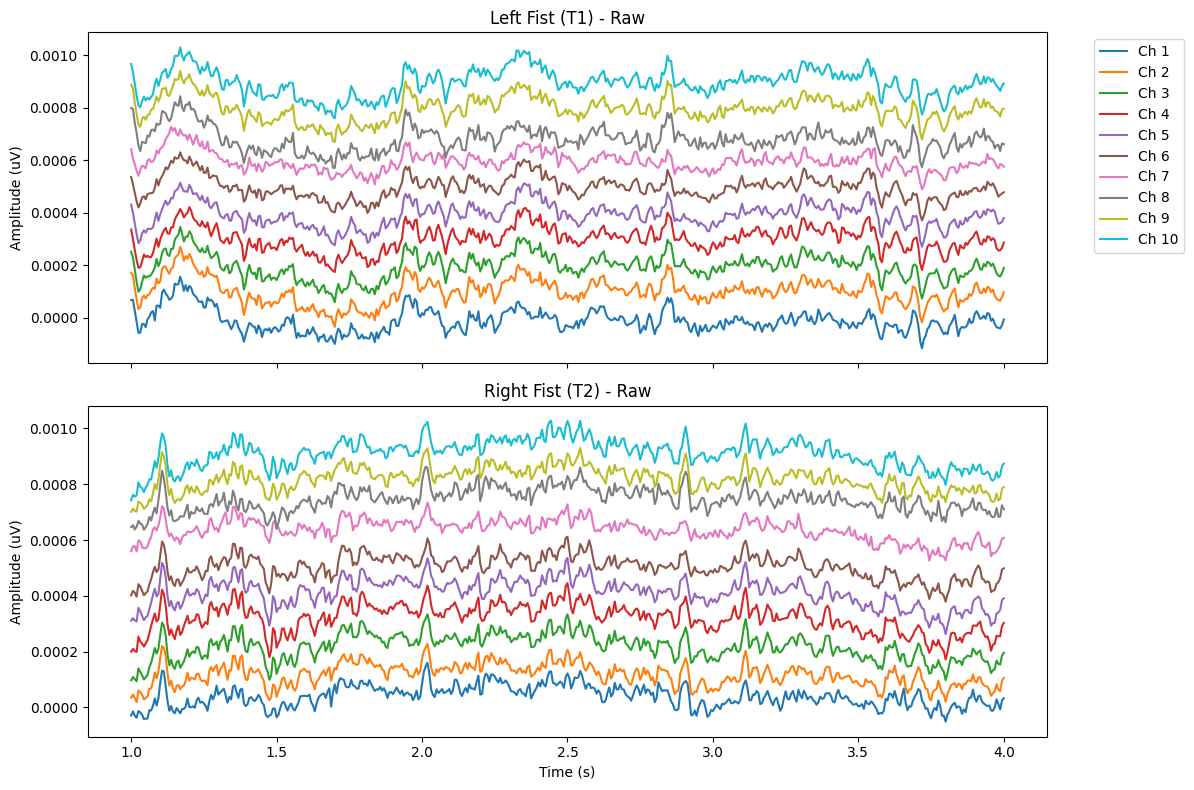

In [ ]:
file = files[0]
raw = mne.io.read_raw_edf(file, preload=True, verbose=False)
event_id = {'T1': 1, 'T2': 2}
events, _ = mne.events_from_annotations(raw, event_id=event_id)
epochs = mne.Epochs(raw, events, event_id=event_id, tmin=1.0, tmax=4.0,
                    baseline=None, preload=True, verbose=False)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot T1 and T2 data
t1_data = epochs['T1'].get_data()[0]
t2_data = epochs['T2'].get_data()[0]
times = epochs.times

# Plot first 10 channels for T1
for ch_idx in range(10):
    axes[0].plot(times, t1_data[ch_idx] + ch_idx * 1e-4, label=f'Ch {ch_idx+1}')
axes[0].set_title('Left Fist (T1) - Raw')
axes[0].legend(loc='upper right', bbox_to_anchor=(1.15, 1))
axes[0].set_ylabel('Amplitude (uV)')

# Plot first 10 channels for T2
for ch_idx in range(10):
    axes[1].plot(times, t2_data[ch_idx] + ch_idx * 1e-4, label=f'Ch {ch_idx+1}')
axes[1].set_title('Right Fist (T2) - Raw')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Amplitude (uV)')

plt.tight_layout()
plt.show()

In [ ]:
def preprocess_data(files, low_cut=8.0, high_cut=30.0, tmin=1.0, tmax=4.0, sfreq=160):
    all_epochs = []
    all_labels = []
    class_counts = {'Left': 0, 'Right': 0}
    dropped_files = 0

    for file in files:
        try:
            raw = mne.io.read_raw_edf(file, preload=True, verbose=True)

            target_channels = ['C3', 'C4', 'Cz', 'FC3', 'FC4', 'CP3', 'CP4']
            available_channels = [ch for ch in raw.ch_names
                               if any(tc in ch.replace('.', '') for tc in target_channels)]

            if len(available_channels) < 3:
                print(f"Skipping {file}: Only found {len(available_channels)} target channels")
                dropped_files += 1
                continue

            raw.pick(available_channels)

            raw.filter(low_cut, high_cut, method='iir', iir_params=dict(order=4, ftype='butter'))

            # Notch filter only at possible frequencies
            nyquist = sfreq / 2
            notch_freqs = [f for f in [50] if f < nyquist]
            if notch_freqs:
                raw.notch_filter(notch_freqs)

            # Resampling
            raw.resample(sfreq, npad='auto')

            # Event handling with flexible mapping
            events, event_mapping = mne.events_from_annotations(raw)
            event_id = {
                'left': event_mapping.get('T1', event_mapping.get('left', -1)),
                'right': event_mapping.get('T2', event_mapping.get('right', -1))
            }
            event_id = {k:v for k,v in event_id.items() if v != -1}

            if not event_id:
                dropped_files += 1
                continue

            # Epoching
            epochs = mne.Epochs(
                raw,
                events,
                event_id=event_id,
                tmin=-1.0,
                tmax=3.0,
                baseline=(-1.0, 0.0),
                reject_by_annotation=True,
                preload=True,
                verbose=False
            )

            # Drop files that don't meet minimum epochs threshold
            if len(epochs) < 5:
                dropped_files += 1
                continue

            # Advanced scaling per channel
            scaler = Scaler(scalings='median')
            epochs_data = scaler.fit_transform(epochs.get_data())

            # Label handling
            labels = []
            for event in epochs.events[:, 2]:
                if event == event_id.get('left'):
                    labels.append(0)
                    class_counts['Left'] += 1
                else:
                    labels.append(1)
                    class_counts['Right'] += 1

            all_epochs.append(epochs_data)
            all_labels.extend(labels)

        except Exception as e:
            print(f"Error in {file}: {str(e)}")
            dropped_files += 1
            continue

    if not all_epochs:
        raise ValueError("No valid data found in any files!")

    X = np.concatenate(all_epochs)
    y = np.array(all_labels)

    print("\n=== Class Distribution BEFORE Balancing ===")
    print(f"Left: {class_counts['Left']} samples ({class_counts['Left']/len(y)*100:.1f}%)")
    print(f"Right: {class_counts['Right']} samples ({class_counts['Right']/len(y)*100:.1f}%)")

    imbalance_threshold = 0.3
    # Balance the class only if the imbalance threshold is above 0.3
    if abs(class_counts['Left'] - class_counts['Right']) / len(y) > imbalance_threshold:
        print("\nApplying SMOTE to balance classes...")
        from imblearn.over_sampling import SMOTE
        sm = SMOTE(random_state=42)
        X_reshaped = X.reshape(X.shape[0], -1)
        X_balanced, y_balanced = sm.fit_resample(X_reshaped, y)
        X_balanced = X_balanced.reshape(-1, X.shape[1], X.shape[2])

        print("\n=== Class Distribution AFTER Balancing ===")
        unique, counts = np.unique(y_balanced, return_counts=True)
        print(f"Left: {counts[0]} samples ({counts[0]/len(y_balanced)*100:.1f}%)")
        print(f"Right: {counts[1]} samples ({counts[1]/len(y_balanced)*100:.1f}%)")

        return X_balanced, y_balanced, class_counts

    print("\n✅ Classes are already balanced within threshold")
    return X, y, class_counts

In [ ]:
X, y, class_counts = preprocess_data(files)

print("\n=== Final Data Shapes ===")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Streaming output truncated to the last 5000 lines.
Extracting EDF parameters from /content/drive/MyDrive/physionet_mi/S077/S077R09.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49

<ipython-input-7-e466059a497d>:46: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 s)

Sam

<ipython-input-7-e466059a497d>:46: RuntimeWarning: All epochs were dropped!
You might need to alter reject/flat-criteria or drop bad channels to avoid this. You can use Epochs.plot_drop_log() to see which channels are responsible for the dropping of epochs.
  epochs = mne.Epochs(


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 s)

Sa

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 s)

Sam

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 s)

Sam

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 15743  =      0.000 ...   122.992 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Use

<ipython-input-7-e466059a497d>:9: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(file, preload=True, verbose=True)


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 8.00, 30.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 s)

Sa


Class Distribution:
Left: 9854 trials (50.1%)
Right: 9816 trials (49.9%)


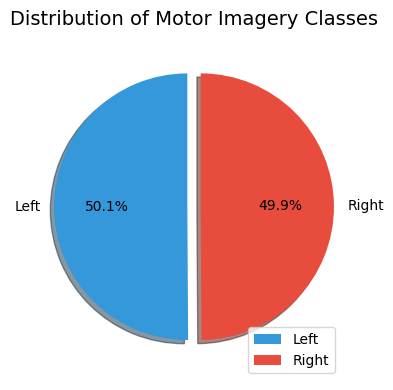

In [ ]:
labels = list(class_counts.keys())
sizes = list(class_counts.values())

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(sizes, labels=labels, autopct='%1.1f%%',
        startangle=90, shadow=True, explode=(0.05, 0.05),
        colors=['#3498db', '#e74c3c'])

ax.axis('equal')

plt.title('Distribution of Motor Imagery Classes', fontsize=14)

plt.legend(loc='lower right')

total = sum(sizes)
print(f"\nClass Distribution:")
for label, size in zip(labels, sizes):
    print(f"{label}: {size} trials ({size/total*100:.1f}%)")

plt.tight_layout()
plt.show()

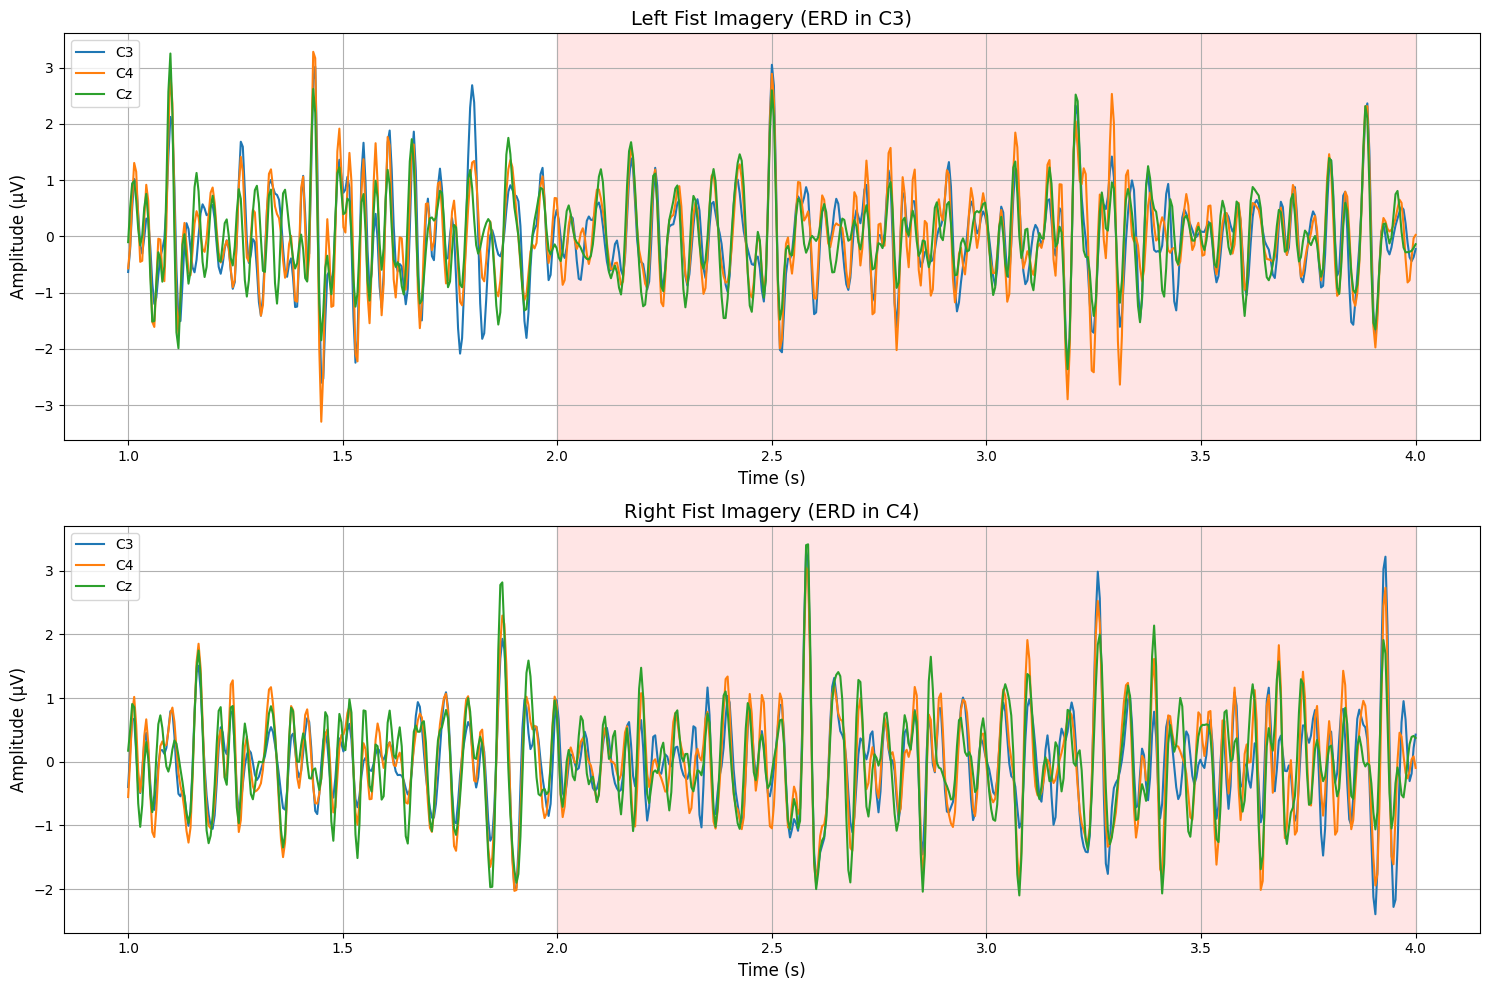

In [ ]:
left_sample = X[y == 0][0]
right_sample = X[y == 1][0]
times = np.linspace(1.0, 4.0, X.shape[2])

plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(times, left_sample[0], label='C3')
plt.plot(times, left_sample[1], label='C4')
plt.plot(times, left_sample[2], label='Cz')
plt.title('Left Fist Imagery (ERD in C3)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.axvspan(2.0, 4.0, alpha=0.1, color='red')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, right_sample[0], label='C3')
plt.plot(times, right_sample[1], label='C4')
plt.plot(times, right_sample[2], label='Cz')
plt.title('Right Fist Imagery (ERD in C4)', fontsize=14)
plt.xlabel('Time (s)', fontsize=12)
plt.ylabel('Amplitude (μV)', fontsize=12)
plt.axvspan(2.0, 4.0, alpha=0.1, color='red')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
print(f"Original X shape: {X.shape}")
print(f"Original y shape: {y.shape}")

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp)


print("\n=== Data Splits ===")
print(f"Train: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Val: {len(X_val)} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

# Convert to PyTorch tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)


y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

print("\nTensor shapes:")
print(f"X_train: {X_train_tensor.shape}, y_train: {y_train_tensor.shape}")
print(f"X_val: {X_val_tensor.shape}, y_val: {y_val_tensor.shape}")
print(f"X_test: {X_test_tensor.shape}, y_test: {y_test_tensor.shape}")

Original X shape: (19670, 3, 641)
Original y shape: (19670,)

=== Data Splits ===
Train: 13768 (70.0%)
Val: 2951 (15.0%)
Test: 2951 (15.0%)

Using device: cuda

Tensor shapes:
X_train: torch.Size([13768, 3, 641, 1]), y_train: torch.Size([13768])
X_val: torch.Size([2951, 3, 641, 1]), y_val: torch.Size([2951])
X_test: torch.Size([2951, 3, 641, 1]), y_test: torch.Size([2951])


In [ ]:
# Define the dataset into a class

class PhysionetEEGDataset(TensorDataset):
    def __init__(self, *tensors, training=False):
        super().__init__(*tensors)
        data = tensors[0].squeeze(-1)
        self.mean = data.mean(dim=(1,2), keepdim=True)
        self.std = data.std(dim=(1,2), keepdim=True)
        self.training = training

    def _random_bandstop(self, x, max_bands=3):
        """Simulate electrode artifacts by removing random frequency bands"""
        if random.random() < 0.3:
            n_bands = random.randint(1, max_bands)
            for _ in range(n_bands):
                band_center = random.uniform(1, 40)
                band_width = random.uniform(0.5, 4)
                fft_signal = torch.fft.rfft(x, dim=1)
                freqs = torch.fft.rfftfreq(x.size(1), d=1/128)
                mask = ~((freqs > band_center-band_width/2) & (freqs < band_center+band_width/2))
                fft_signal *= mask.unsqueeze(0).float()
                x = torch.fft.irfft(fft_signal, n=x.size(1))
        return x

    def _channel_dropout(self, x, p=0.2):
        """Randomly zero out entire channels"""
        if random.random() < p:
            chan_idx = random.randint(0, x.size(0)-1)
            x[chan_idx] = 0
        return x

    def _gaussian_noise(self, x, std=0.05):
        """Add channel-wise noise"""
        if random.random() < 0.5:
            noise = torch.randn_like(x) * std * x.std()
            return x + noise
        return x

    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        x = x.squeeze(-1)  # [3,641]
        x = (x - self.mean[index]) / (self.std[index] + 1e-7)

        if self.training:
            # Apply augmentations with probability
            x = self._random_bandstop(x)
            x = self._channel_dropout(x)
            x = self._gaussian_noise(x)

            # Time warping
            if random.random() < 0.3:
                orig_len = x.size(1)
                new_len = random.randint(orig_len-20, orig_len+20)
                x = F.interpolate(x.unsqueeze(0), size=new_len, mode='linear').squeeze(0)
                if new_len > orig_len:
                    x = x[:, :orig_len]
                else:
                    padding = orig_len - new_len
                    x = F.pad(x, (0, padding))

        return x.unsqueeze(0), y

In [ ]:
train_dataset = PhysionetEEGDataset(X_train_tensor, y_train_tensor)
val_dataset = PhysionetEEGDataset(X_val_tensor, y_val_tensor)
test_dataset = PhysionetEEGDataset(X_test_tensor, y_test_tensor)

# Data loaders
batch_size = 64
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    persistent_workers=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size*2,
    num_workers=2
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size*2,
    num_workers=2
)

In [ ]:
### Experiment 1: CNN with 32 initial filters and 14 Kernel Size ###

class EEGCNN_V1(nn.Module):
    def __init__(self, n_classes=2, in_channels=1, n_channels=3, n_timepoints=641):
        super().__init__()

        self.temp_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, (1, 15), padding=(0, 7)),
            nn.LayerNorm([32, n_channels, n_timepoints]),
            nn.SiLU(),
            nn.MaxPool2d((1, 2), ceil_mode=True),
            nn.Dropout(0.3)
        )

        self.spatial_conv = nn.Sequential(
            nn.Conv2d(32, 64, (n_channels, 1)),
            nn.LayerNorm([64, 1, 321]),
            nn.SiLU(),
            nn.Dropout(0.4)
        )

        self.temp_conv2 = nn.Sequential(
            nn.Conv2d(64, 128, (1, 9), padding=(0, 4)),
            nn.LayerNorm([128, 1, 321]),
            nn.SiLU(),
            nn.MaxPool2d((1, 4), ceil_mode=True),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 81, 512),
            nn.LayerNorm(512),
            nn.SiLU(),
            nn.Dropout(0.6),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        x = self.temp_conv1(x)
        x = self.spatial_conv(x)
        x = self.temp_conv2(x)
        return self.classifier(x)

In [ ]:
### Experiment 2: CNN with 16 initial filter and 31 Kernel size ###

class EEGCNN_V2(nn.Module):
    def __init__(self, n_classes=2, in_channels=3, n_channels=3, n_timepoints=641):
        super(EEGCNN, self).__init__()

        self.temp_conv = nn.Sequential(
            nn.Conv2d(in_channels, 16, (1, 31), padding=(0, 7)),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.MaxPool2d((1, 4)),
            nn.Dropout(0.3)
        )

        self.spatial_conv = nn.Sequential(
            nn.Conv2d(16, 32, (n_channels, 1)),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d((1, 5)),
            nn.Dropout(0.4)
        )

        self.temp_refine = nn.Sequential(
            nn.Conv2d(32, 64, (1, 15), padding=(0, 7)),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 64, (1, 7), padding=(0, 3)),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*1*16, 128),
            nn.ELU(),
            nn.Dropout(0.6),
            nn.Linear(128, n_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.temp_conv(x)
        x = self.spatial_conv(x)
        x = self.temp_refine(x)
        return self.classifier(x)


In [ ]:
### Experiment 3: CNN with Optimized version of Experiment 2 ###

class EEGCNN_V3(nn.Module):
    def __init__(self, n_classes=2, in_channels=3, n_timepoints=641):
        super(EEGCNN, self).__init__()

        self.temp_conv = nn.Sequential(
            nn.Conv2d(1, 16, (1, 31), padding=(0, 15)),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.MaxPool2d((1, 4)),
            nn.Dropout(0.3)
        )

        self.spatial_conv = nn.Sequential(
            nn.Conv2d(16, 32, (in_channels, 1)),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d((1, 5)),
            nn.Dropout(0.4)
        )

        self.temp_refine = nn.Sequential(
            nn.Conv2d(32, 64, (1, 15), padding=(0, 7)),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.Conv2d(64, 64, (1, 7), padding=(0, 3)),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.5)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*1*16, 128),
            nn.ELU(),
            nn.Dropout(0.6),
            nn.Linear(128, n_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.temp_conv(x)
        x = self.spatial_conv(x)
        x = self.temp_refine(x)
        return self.classifier(x)

In [ ]:
class EEGTransformer(nn.Module):
    def __init__(self, input_dim=3, seq_len=641, n_classes=2, d_model=128, nhead=8, num_layers=3, dropout=0.2):
        super(EEGTransformer, self).__init__()
        self.seq_len = seq_len
        self.d_model = d_model

        # Downsampling: [batch, 3, 641] -> [batch, 3, 160]
        self.downsample = nn.AvgPool1d(kernel_size=4, stride=4)
        reduced_seq_len = seq_len // 4

        # Project input_dim -> d_model
        self.input_proj = nn.Linear(input_dim, d_model)

        # Positional Encoding
        position = torch.arange(reduced_seq_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(1, reduced_seq_len, d_model)
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=256,
            dropout=dropout, batch_first=True, norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Classification Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 64),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(64, n_classes)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)

        x = self.downsample(x)
        x = x.permute(0, 2, 1)
        x = self.input_proj(x)
        x = x + self.pe[:, :x.size(1), :]
        x = self.transformer(x)
        x = x.mean(dim=1)
        return self.classifier(x)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class EEGHybrid(nn.Module):
    def __init__(self, n_classes=2, in_channels=1, n_eeg_channels=3, seq_len=641,
                 num_heads=4, ff_dim=256, num_layers=3, dropout=0.3):
        super().__init__()

        # CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels, 32, (1, 31), padding=(0, 15), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d((1, 2)),

            nn.Conv2d(32, 64, (n_eeg_channels, 1), bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),

            nn.Conv2d(64, 64, (1, 15), padding=(0, 7), groups=64, bias=False),
            nn.Conv2d(64, 128, (1, 1), bias=False),
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d((1, 4)),
            nn.Dropout(dropout)
        )

        # Transformer Adapter
        self.transformer_proj = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=1),
            nn.LayerNorm([128, 80]),
            nn.ELU()
        )

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(128, dropout, max_len=100)

        # Transformer Encoder
        encoder_layers = TransformerEncoderLayer(
            d_model=128,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers)

        # Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.LayerNorm(128),
            nn.Linear(128, 256),
            nn.ELU(),
            nn.Dropout(dropout),
            nn.Linear(256, n_classes)
        )

        self._init_weights()

    def _init_weights(self):
      for m in self.modules():
          if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
              if m.bias is not None:
                  nn.init.zeros_(m.bias)
          elif isinstance(m, nn.Linear):
              nn.init.xavier_normal_(m.weight)
              if m.bias is not None:
                  nn.init.zeros_(m.bias)
          elif isinstance(m, (nn.BatchNorm2d, nn.LayerNorm)):
              nn.init.ones_(m.weight)
              nn.init.zeros_(m.bias)

      for p in self.transformer.parameters():
          if p.dim() > 1:
              nn.init.xavier_uniform_(p)

    def forward(self, x):
        x = self.cnn(x)
        x = x.squeeze(2)

        x = self.transformer_proj(x)
        x = x.permute(0, 2, 1)
        x = self.pos_encoder(x)

        x = self.transformer(x)
        x = x.permute(0, 2, 1)

        return self.classifier(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [ ]:
# Initialize model and Training setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)


# ModelS
model = EEGHybrid().to(device)
# model = EEGCNN_V1().to(device)
# model = EEGCNN_V2().to(device)
# model = EEGCNN_V3().to(device)
# model = EEGTransformer().to(device)


torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)


class_weights = torch.tensor(
    compute_class_weight('balanced', classes=np.unique(y_train), y=y_train),
    dtype=torch.float32
).to(device)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.3
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,
    weight_decay=1e-3
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=7,
    verbose=True
)

class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
def train_model():
    scaler = GradScaler()
    early_stopper = EarlyStopping(patience=15)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    best_val_acc = 0.0
    best_val_loss = float('inf')

    for epoch in range(50):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            optimizer.zero_grad(set_to_none=True)

            with autocast():
                outputs = model(xb)
                loss = criterion(outputs, yb)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)

        train_loss /= len(train_loader)
        train_acc = correct / total
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step(val_loss)

        early_stopper(val_loss)
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epoch+1}")
            break

        lr = optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f} | "
              f"Best Val Acc: {best_val_acc:.4f} | "
              f"LR: {lr:.2e}")

    print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.4f}")

    return history

history = train_model()

<ipython-input-20-7a82debaa827>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-20-7a82debaa827>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: Train Loss: 0.7363, Acc: 0.5005 | Val Loss: 0.7069, Acc: 0.4992 | Best Val Acc: 0.4992 | LR: 2.00e-04
Epoch 2: Train Loss: 0.6996, Acc: 0.5405 | Val Loss: 0.6902, Acc: 0.5612 | Best Val Acc: 0.5612 | LR: 2.00e-04
Epoch 3: Train Loss: 0.6902, Acc: 0.5760 | Val Loss: 0.6847, Acc: 0.5913 | Best Val Acc: 0.5913 | LR: 2.00e-04
Epoch 4: Train Loss: 0.6874, Acc: 0.5846 | Val Loss: 0.6872, Acc: 0.5693 | Best Val Acc: 0.5913 | LR: 2.00e-04
Epoch 5: Train Loss: 0.6813, Acc: 0.5949 | Val Loss: 0.6726, Acc: 0.6049 | Best Val Acc: 0.6049 | LR: 2.00e-04
Epoch 6: Train Loss: 0.6777, Acc: 0.6031 | Val Loss: 0.6782, Acc: 0.5971 | Best Val Acc: 0.6049 | LR: 2.00e-04
Epoch 7: Train Loss: 0.6769, Acc: 0.5959 | Val Loss: 0.6719, Acc: 0.6117 | Best Val Acc: 0.6117 | LR: 2.00e-04
Epoch 8: Train Loss: 0.6770, Acc: 0.6081 | Val Loss: 0.6691, Acc: 0.6134 | Best Val Acc: 0.6134 | LR: 2.00e-04
Epoch 9: Train Loss: 0.6730, Acc: 0.6126 | Val Loss: 0.6706, Acc: 0.6028 | Best Val Acc: 0.6134 | LR: 2.00e-04
E


Test Results: Loss=0.6689, Acc=0.6276

Classification Report:
              precision    recall  f1-score   support

        Left       0.62      0.66      0.64      1478
       Right       0.64      0.59      0.61      1473

    accuracy                           0.63      2951
   macro avg       0.63      0.63      0.63      2951
weighted avg       0.63      0.63      0.63      2951


Confusion Matrix:


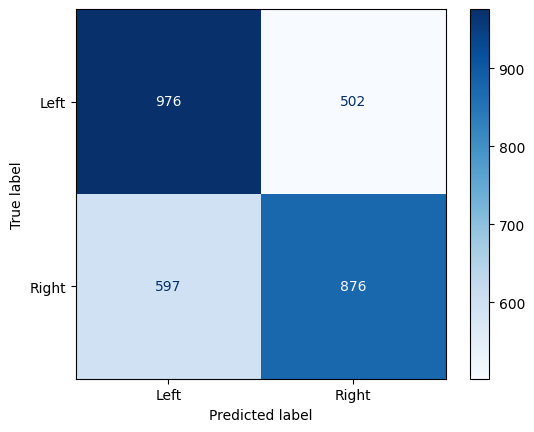

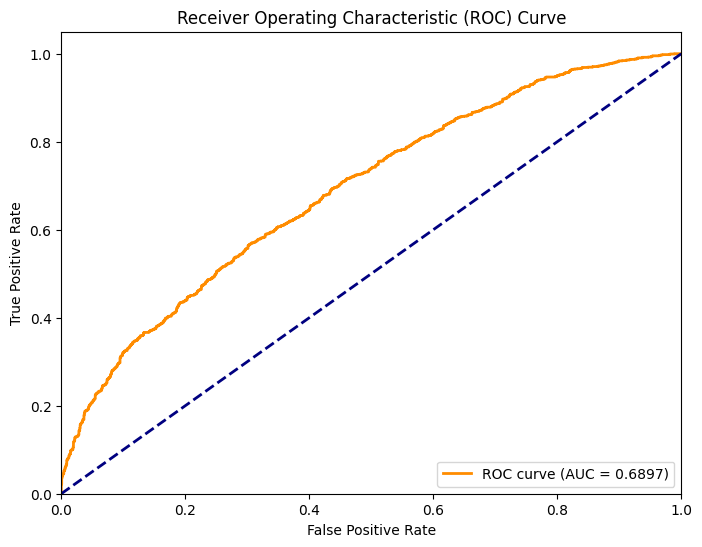


Cohen's Kappa: 0.2551
Balanced Accuracy: 0.6275
Improvement over chance: 12.76%


In [ ]:
from sklearn.metrics import roc_curve, auc, cohen_kappa_score, balanced_accuracy_score
import numpy as np

def evaluate_model():
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    test_loss = 0
    test_correct = 0
    test_total = 0

    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)

            test_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == yb).sum().item()
            test_total += yb.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_acc = test_correct / test_total

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    print(f"\nTest Results: Loss={test_loss/len(test_loader):.4f}, Acc={test_acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=['Left', 'Right']
    ))

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Left', 'Right'])

    print("\nConfusion Matrix:")
    disp.plot(cmap='Blues')
    plt.show()

    right_hand_probs = all_probs[:, 1]
    fpr, tpr, _ = roc_curve(all_labels, right_hand_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    kappa = cohen_kappa_score(all_labels, all_preds)
    print(f"\nCohen's Kappa: {kappa:.4f}")

    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    print(f"Balanced Accuracy: {balanced_acc:.4f}")

    print(f"Improvement over chance: {(test_acc - 0.5) * 100:.2f}%")

    return {
        'accuracy': test_acc,
        'balanced_accuracy': balanced_acc,
        'auc': roc_auc,
        'kappa': kappa,
        'confusion_matrix': cm,
        'classification_report': classification_report(
            all_labels,
            all_preds,
            target_names=['Left', 'Right'],
            output_dict=True
        )
    }


results = evaluate_model()

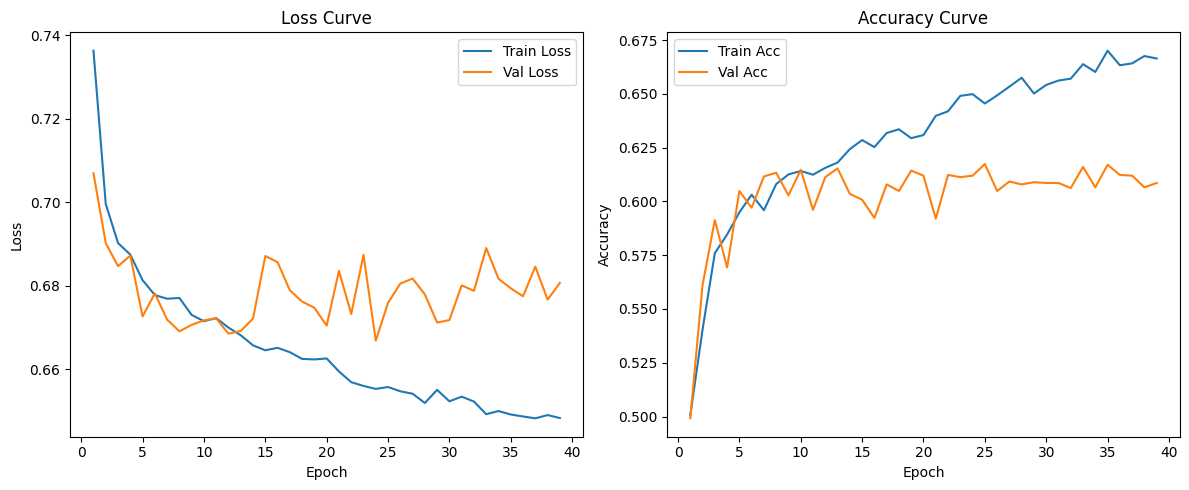

In [ ]:
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

In [ ]:
scaler = GradScaler()

def kfold_cross_validation(X, y, n_splits=5, epochs=100, batch_size=64):

    X_np = X.numpy() if isinstance(X, torch.Tensor) else X
    y_np = y.numpy() if isinstance(y, torch.Tensor) else y

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = {
        'fold_train_loss': [],
        'fold_val_loss': [],
        'fold_train_acc': [],
        'fold_val_acc': [],
        'test_metrics': [],
        'models': []
    }

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):
        print(f"\n=== Fold {fold+1}/{n_splits} ===")

        train_fold = PhysionetEEGDataset(
            X[train_idx],
            y[train_idx],
            training=True
        )
        val_fold = PhysionetEEGDataset(
            X[val_idx],
            y[val_idx],
            training=False
        )

        train_loader = DataLoader(
            train_fold,
            batch_size=batch_size,
            shuffle=True,
            num_workers=2,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_fold,
            batch_size=batch_size*2,
            num_workers=2
        )

        model = EEGHybrid().to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=7
        )

        best_val_acc = 0.0
        fold_history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        for epoch in range(epochs):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0

            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)

                xb = xb.to(torch.float32)

                optimizer.zero_grad()
                with autocast():
                    outputs = model(xb)
                    loss = criterion(outputs, yb)

                scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_correct += (preds == yb).sum().item()
                train_total += yb.size(0)

            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0

            with torch.no_grad():
                for xb, yb in val_loader:
                    xb, yb = xb.to(device), yb.to(device)

                    xb = xb.to(torch.float32)

                    outputs = model(xb)
                    loss = criterion(outputs, yb)

                    val_loss += loss.item()
                    _, preds = torch.max(outputs, 1)
                    val_correct += (preds == yb).sum().item()
                    val_total += yb.size(0)

            train_loss /= len(train_loader)
            train_acc = train_correct / train_total
            val_loss /= len(val_loader)
            val_acc = val_correct / val_total

            scheduler.step(val_loss)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = deepcopy(model.state_dict())

            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['val_loss'].append(val_loss)
            fold_history['val_acc'].append(val_acc)

            print(f"Epoch {epoch+1}/{epochs} | "
                  f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
                  f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        results['fold_train_loss'].append(fold_history['train_loss'])
        results['fold_val_loss'].append(fold_history['val_loss'])
        results['fold_train_acc'].append(fold_history['train_acc'])
        results['fold_val_acc'].append(fold_history['val_acc'])
        results['models'].append(best_model)

        print(f"Fold {fold+1} Best Val Acc: {best_val_acc:.4f}")

    return results


# kfold_results = kfold_cross_validation(
#     X_train_tensor,
#     y_train_tensor,
#     n_splits=5,
#     epochs=50,
#     batch_size=64
# )

<ipython-input-16-be102700a42c>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-16-be102700a42c>:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Fold Summary Table:
                  Fold     Best Val Acc   Final Val Loss
0                    1         0.622004          0.67068
1                    2         0.618373         0.669976
2                    3         0.631082         0.676827
3                    4         0.630948         0.668141
4                    5         0.621141         0.686888
Mean ± Std  Mean ± Std  0.6247 ± 0.0053  0.6745 ± 0.0068


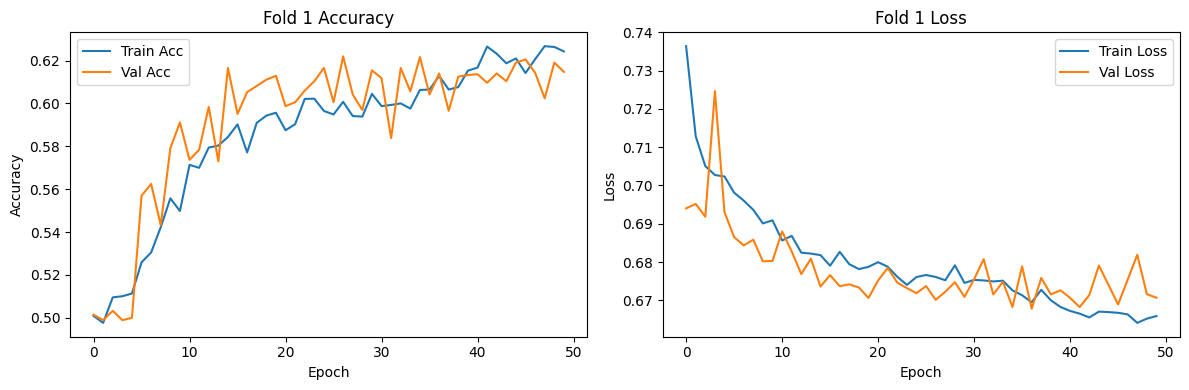

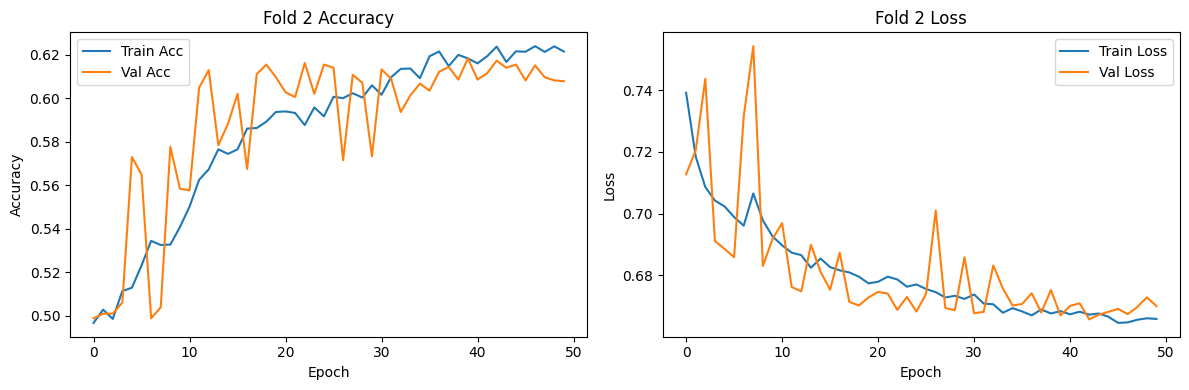

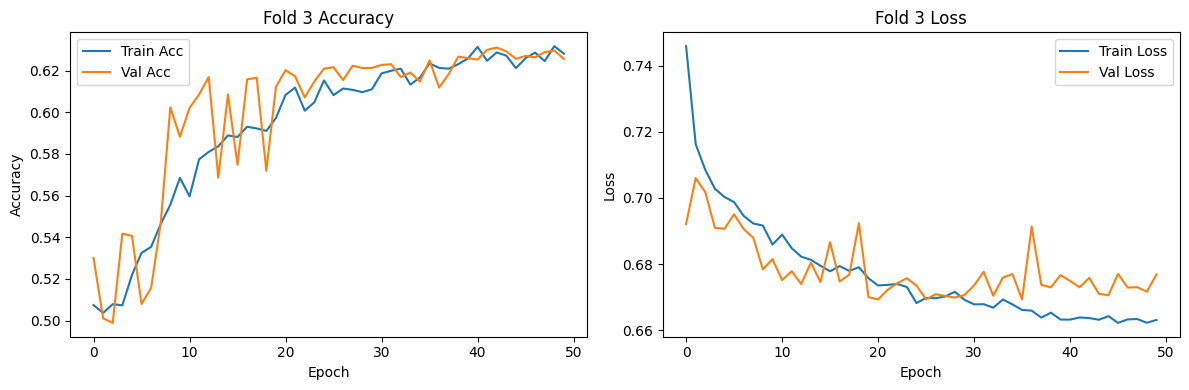

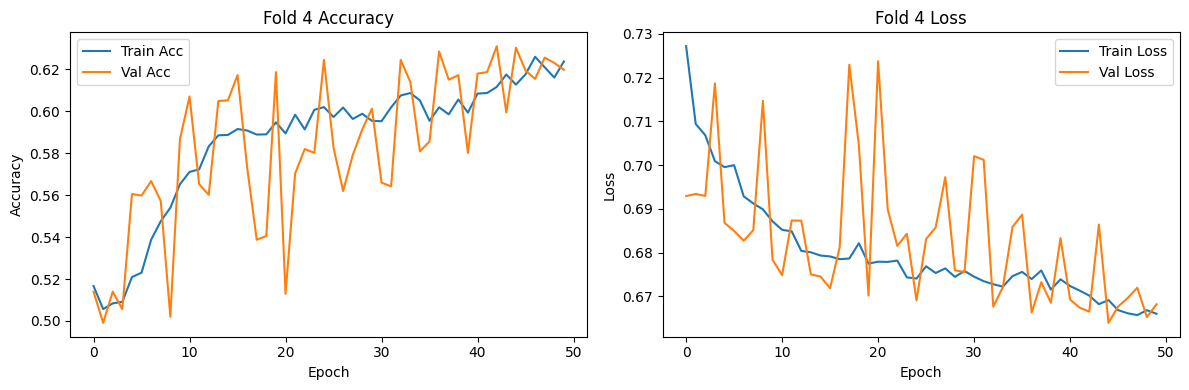

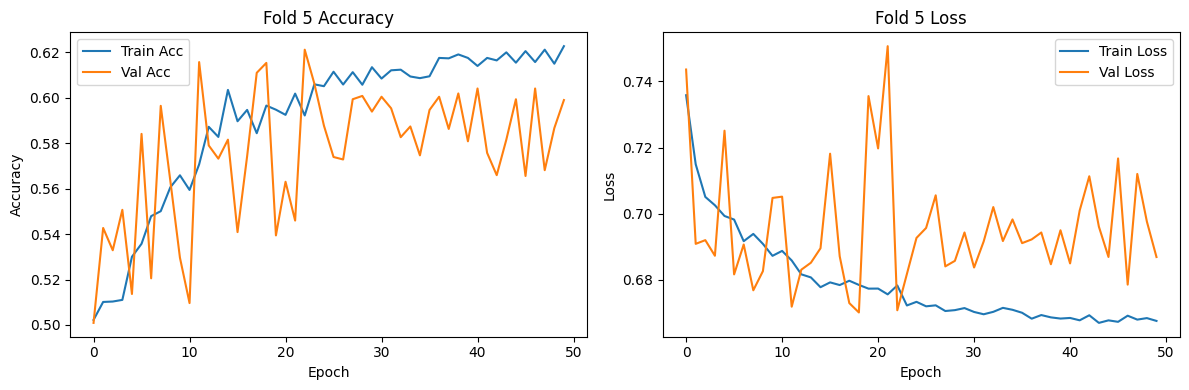

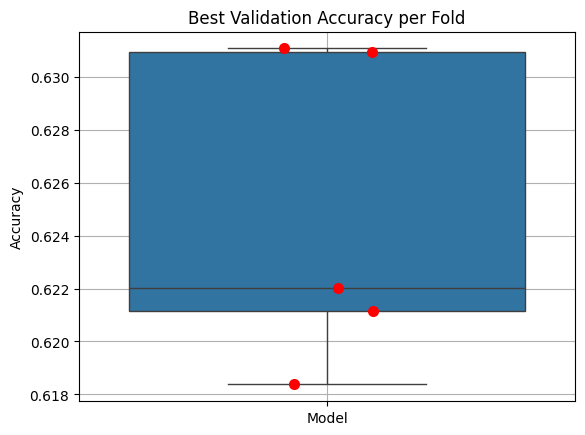


Generating confusion matrices from each fold...


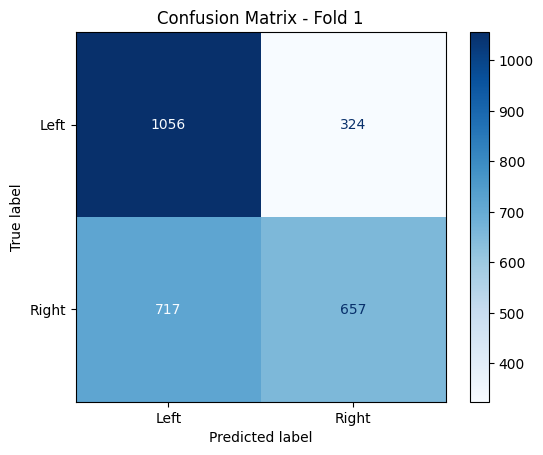

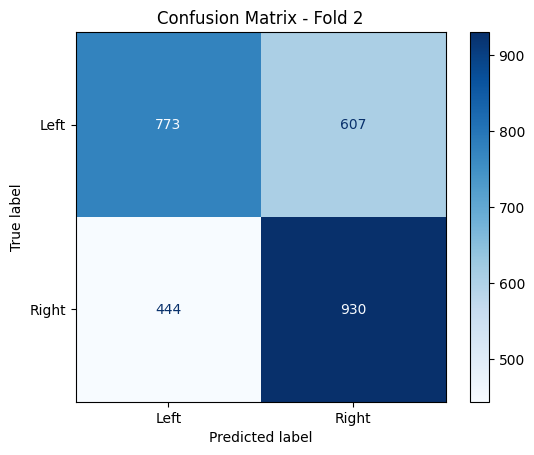

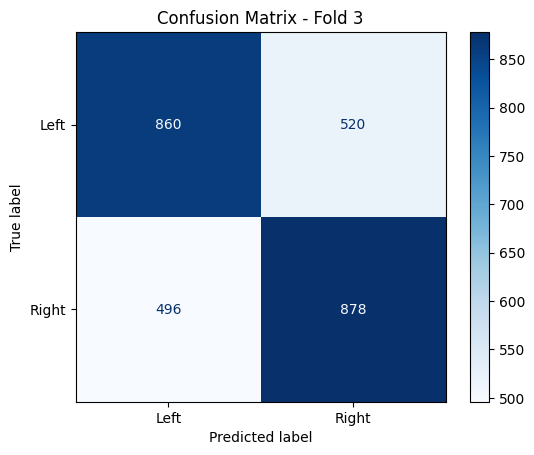

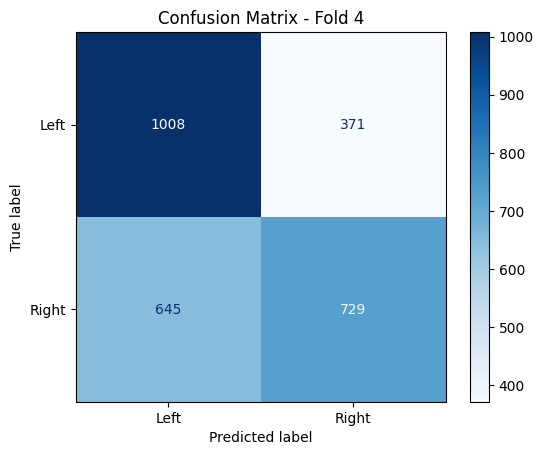

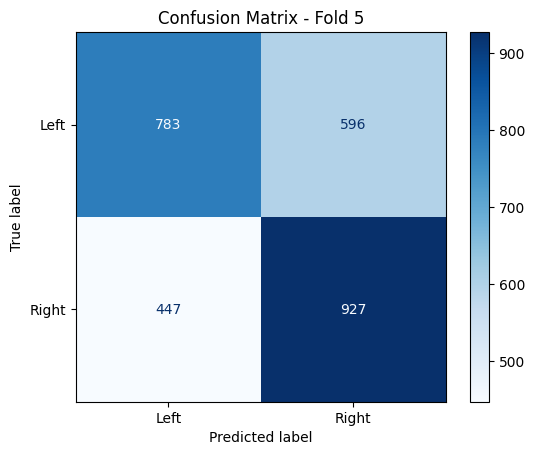

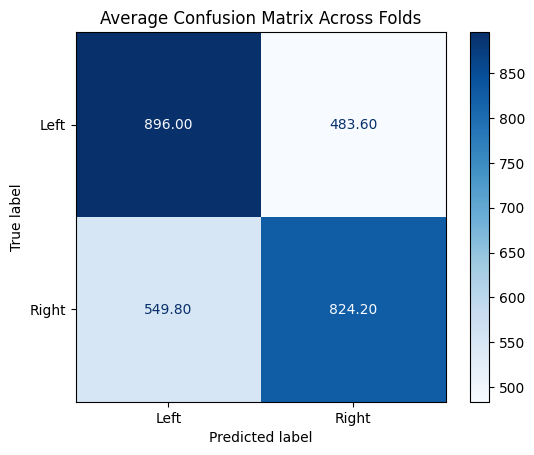


Evaluating on test set using best model from each fold...
Fold 1 Test Accuracy: 0.6198
Fold 2 Test Accuracy: 0.6225
Fold 3 Test Accuracy: 0.6323
Fold 4 Test Accuracy: 0.6306
Fold 5 Test Accuracy: 0.6045

Test Accuracy Across Folds: [0.6197899017282277, 0.6225008471704507, 0.632328024398509, 0.6306336834971196, 0.6045408336157235]
Mean ± Std Test Accuracy: 0.6220 ± 0.0099


In [ ]:
def evaluate_kfold_results(kfold_results, X, y, num_classes, class_names=None,
                           X_test=None, y_test=None):
    assert len(X) == len(y), f"Inconsistent lengths: X={len(X)}, y={len(y)}"
    folds = len(kfold_results['fold_val_acc'])

    best_val_accs = [max(acc) for acc in kfold_results['fold_val_acc']]
    final_val_loss = [loss[-1] for loss in kfold_results['fold_val_loss']]

    print("\nFold Summary Table:")
    df = pd.DataFrame({
        "Fold": list(range(1, folds + 1)),
        "Best Val Acc": best_val_accs,
        "Final Val Loss": final_val_loss
    })
    df.loc["Mean ± Std"] = [
        "Mean ± Std",
        f"{np.mean(best_val_accs):.4f} ± {np.std(best_val_accs):.4f}",
        f"{np.mean(final_val_loss):.4f} ± {np.std(final_val_loss):.4f}"
    ]
    print(df)

    for i in range(folds):
        epochs = range(len(kfold_results['fold_val_acc'][i]))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, kfold_results['fold_train_acc'][i], label='Train Acc')
        plt.plot(epochs, kfold_results['fold_val_acc'][i], label='Val Acc')
        plt.title(f'Fold {i+1} Accuracy')
        plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, kfold_results['fold_train_loss'][i], label='Train Loss')
        plt.plot(epochs, kfold_results['fold_val_loss'][i], label='Val Loss')
        plt.title(f'Fold {i+1} Loss')
        plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

        plt.tight_layout()
        plt.show()

    sns.boxplot(data=best_val_accs)
    sns.stripplot(data=best_val_accs, color='red', size=8, jitter=True)
    plt.title("Best Validation Accuracy per Fold")
    plt.ylabel("Accuracy")
    plt.xticks([0], ['Model'])
    plt.grid(True)
    plt.show()

    print("\nGenerating confusion matrices from each fold...")

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    X_np = X.numpy() if isinstance(X, torch.Tensor) else X
    y_np = y.numpy() if isinstance(y, torch.Tensor) else y

    all_cm = np.zeros((num_classes, num_classes))

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_np, y_np)):
        model = EEGHybrid().to(device)
        model.load_state_dict(kfold_results['models'][fold_idx])
        model.eval()

        val_set = PhysionetEEGDataset(X[val_idx], y[val_idx], training=False)
        val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                outputs = model(xb)
                preds = torch.argmax(outputs, dim=1).cpu()
                y_true.extend(yb.numpy())
                y_pred.extend(preds.numpy())

        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        all_cm += cm
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"Confusion Matrix - Fold {fold_idx+1}")
        plt.show()

    avg_cm = all_cm / folds
    disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format=".2f")
    plt.title("Average Confusion Matrix Across Folds")
    plt.show()

    if X_test is not None and y_test is not None:
        print("\nEvaluating on test set using best model from each fold...")
        test_accs = []

        for fold_idx in range(folds):
            model = EEGHybrid().to(device)
            model.load_state_dict(kfold_results['models'][fold_idx])
            model.eval()

            test_set = PhysionetEEGDataset(X_test, y_test, training=False)
            test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

            correct, total = 0, 0
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb, yb = xb.to(device), yb.to(device)
                    outputs = model(xb)
                    preds = torch.argmax(outputs, dim=1)
                    correct += (preds == yb).sum().item()
                    total += yb.size(0)

            acc = correct / total
            test_accs.append(acc)
            print(f"Fold {fold_idx+1} Test Accuracy: {acc:.4f}")

        mean_test = np.mean(test_accs)
        std_test = np.std(test_accs)
        print(f"\nTest Accuracy Across Folds: {test_accs}")
        print(f"Mean ± Std Test Accuracy: {mean_test:.4f} ± {std_test:.4f}")

evaluate_kfold_results(
    kfold_results=kfold_results,
    X=X_train_tensor,
    y=y_train_tensor,
    num_classes=2,
    class_names=['Left', 'Right'],
    X_test=X_test_tensor,
    y_test=y_test_tensor
)


Fold-wise Performance Summary
+------------+--------+--------------------+--------------------+------------------+
|            | Fold   | Best Val Acc       | Final Val Loss     |   Epochs Trained |
+============+========+====================+====================+==================+
| 0          | 1      | 0.6220043572984749 | 0.6706801192326979 |               50 |
+------------+--------+--------------------+--------------------+------------------+
| 1          | 2      | 0.6183732752360204 | 0.6699758172035217 |               50 |
+------------+--------+--------------------+--------------------+------------------+
| 2          | 3      | 0.6310820624546115 | 0.6768267533995889 |               50 |
+------------+--------+--------------------+--------------------+------------------+
| 3          | 4      | 0.6309480566654558 | 0.6681413975628939 |               50 |
+------------+--------+--------------------+--------------------+------------------+
| 4          | 5      | 0.62114057

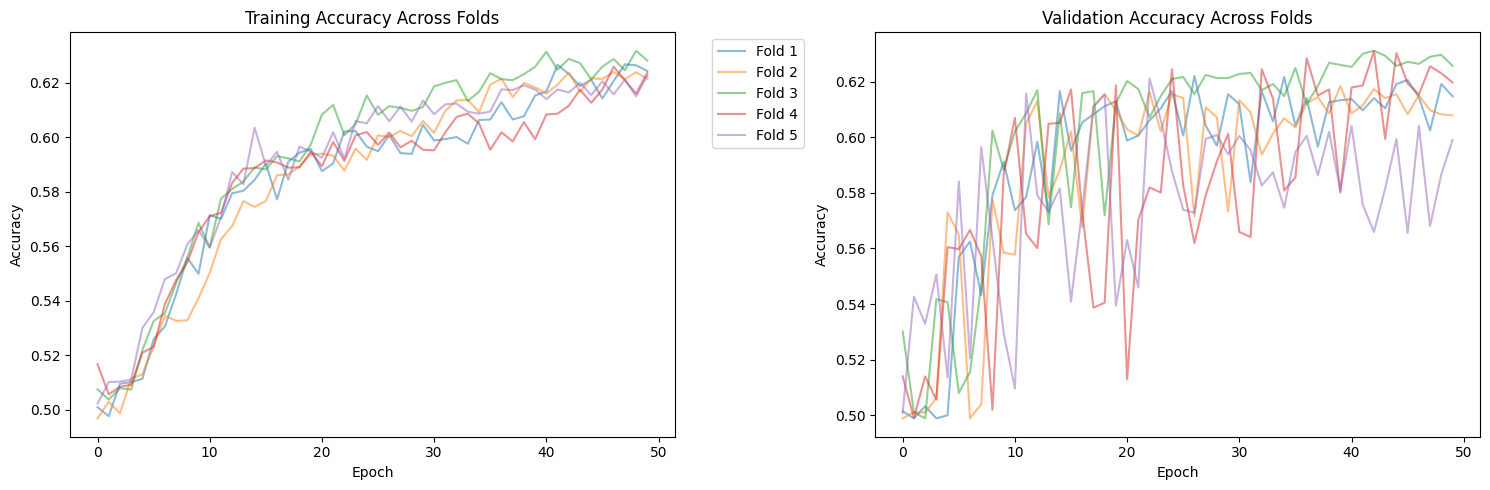


Confusion Matrices


Evaluating folds:   0%|          | 0/5 [00:00<?, ?it/s]

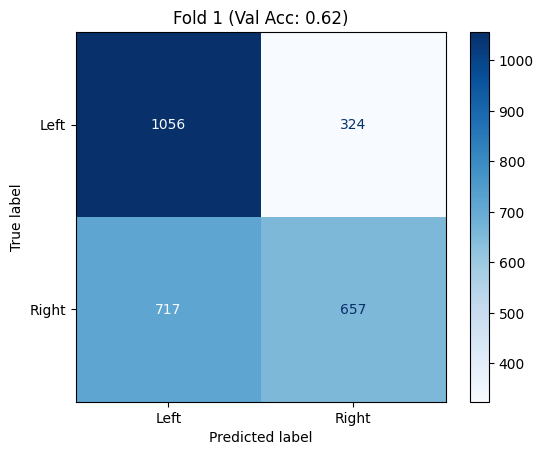

Evaluating folds:  20%|██        | 1/5 [00:00<00:03,  1.12it/s]


Classification Report - Fold 1:
              precision    recall  f1-score   support

        Left     0.5956    0.7652    0.6698      1380
       Right     0.6697    0.4782    0.5580      1374

    accuracy                         0.6220      2754
   macro avg     0.6327    0.6217    0.6139      2754
weighted avg     0.6326    0.6220    0.6140      2754



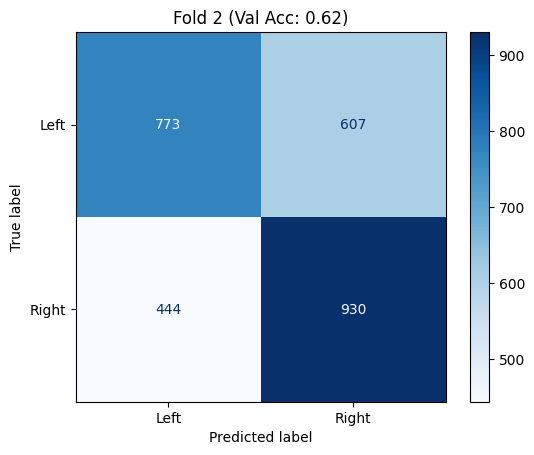

Evaluating folds:  40%|████      | 2/5 [00:01<00:02,  1.23it/s]


Classification Report - Fold 2:
              precision    recall  f1-score   support

        Left     0.6352    0.5601    0.5953      1380
       Right     0.6051    0.6769    0.6390      1374

    accuracy                         0.6184      2754
   macro avg     0.6201    0.6185    0.6171      2754
weighted avg     0.6202    0.6184    0.6171      2754



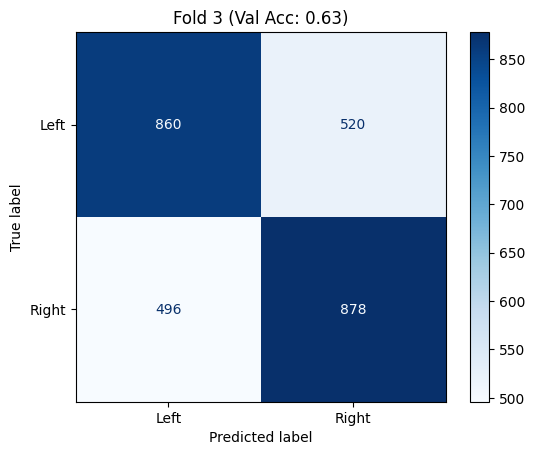

Evaluating folds:  60%|██████    | 3/5 [00:02<00:01,  1.32it/s]


Classification Report - Fold 3:
              precision    recall  f1-score   support

        Left     0.6342    0.6232    0.6287      1380
       Right     0.6280    0.6390    0.6335      1374

    accuracy                         0.6311      2754
   macro avg     0.6311    0.6311    0.6311      2754
weighted avg     0.6311    0.6311    0.6311      2754



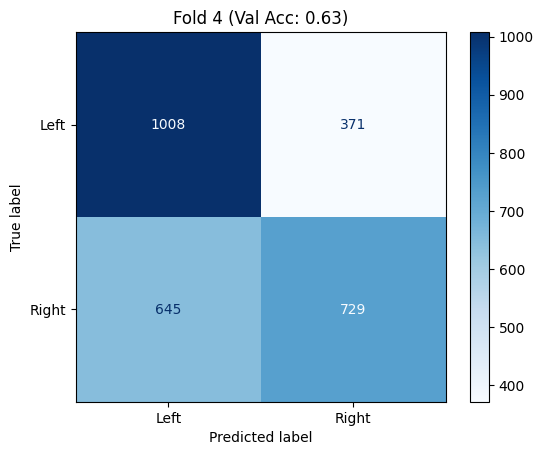

Evaluating folds:  80%|████████  | 4/5 [00:03<00:00,  1.32it/s]


Classification Report - Fold 4:
              precision    recall  f1-score   support

        Left     0.6098    0.7310    0.6649      1379
       Right     0.6627    0.5306    0.5893      1374

    accuracy                         0.6309      2753
   macro avg     0.6363    0.6308    0.6271      2753
weighted avg     0.6362    0.6309    0.6272      2753



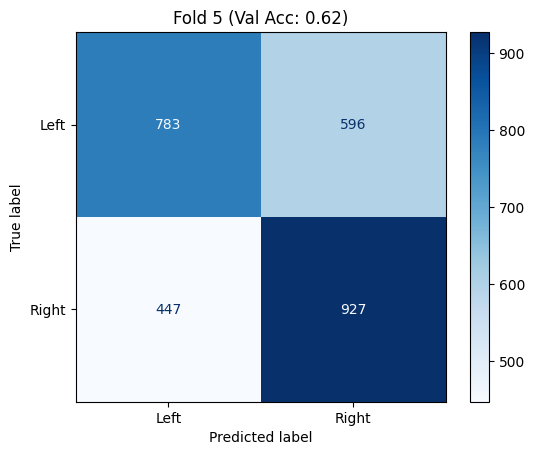

Evaluating folds: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


Classification Report - Fold 5:
              precision    recall  f1-score   support

        Left     0.6366    0.5678    0.6002      1379
       Right     0.6087    0.6747    0.6400      1374

    accuracy                         0.6211      2753
   macro avg     0.6226    0.6212    0.6201      2753
weighted avg     0.6227    0.6211    0.6201      2753



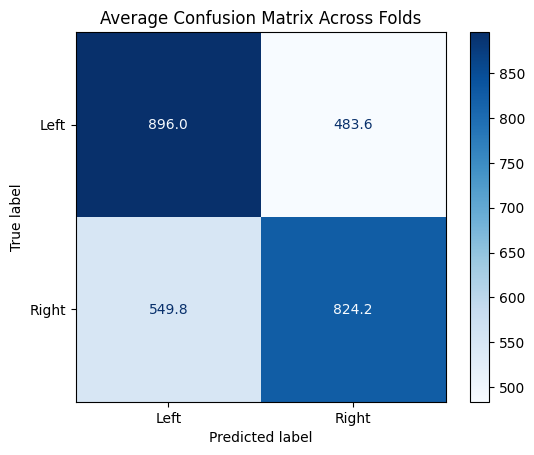


Test Set Evaluation


Evaluating on test set: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]



Individual Fold Performance on Test Set:
+----+--------+------------+------------+
|    |   Fold |   Accuracy |   F1 Score |
+====+========+============+============+
|  0 |      1 |   0.61979  |   0.612061 |
+----+--------+------------+------------+
|  1 |      2 |   0.622501 |   0.621606 |
+----+--------+------------+------------+
|  2 |      3 |   0.632328 |   0.632184 |
+----+--------+------------+------------+
|  3 |      4 |   0.630634 |   0.626815 |
+----+--------+------------+------------+
|  4 |      5 |   0.604541 |   0.603643 |
+----+--------+------------+------------+

Mean Test Accuracy: 0.6220 ± 0.0099
Mean F1 Score: 0.6193 ± 0.0103

--------------------------------------------------
Ensemble Evaluation
--------------------------------------------------

Ensemble Classification Report:
              precision    recall  f1-score   support

        Left     0.6201    0.6516    0.6354      1478
       Right     0.6316    0.5995    0.6151      1473

    accuracy            

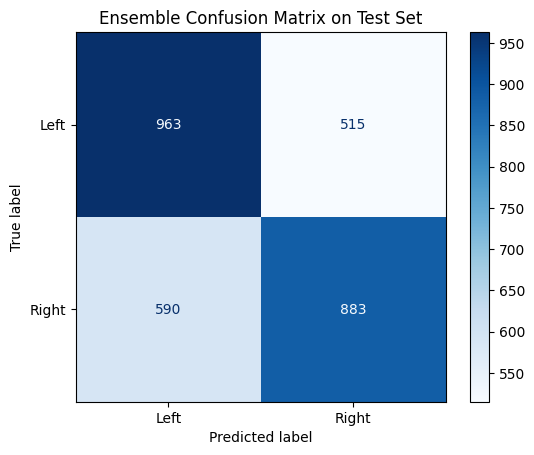

In [ ]:
def evaluate_kfold_results(kfold_results, X, y, num_classes, class_names=None,
                          X_test=None, y_test=None, ensemble=True, device='cuda'):
    X_np = X.numpy() if isinstance(X, torch.Tensor) else X
    y_np = y.numpy() if isinstance(y, torch.Tensor) else y
    folds = len(kfold_results['fold_val_acc'])

    print("\n" + "="*50)
    print("Fold-wise Performance Summary")
    print("="*50)

    best_val_accs = [max(acc) for acc in kfold_results['fold_val_acc']]
    final_val_loss = [loss[-1] for loss in kfold_results['fold_val_loss']]

    df = pd.DataFrame({
        "Fold": list(range(1, folds+1)),
        "Best Val Acc": best_val_accs,
        "Final Val Loss": final_val_loss,
        "Epochs Trained": [len(acc) for acc in kfold_results['fold_val_acc']]
    })

    df.loc['Mean ± Std'] = [
        'All',
        f"{np.mean(best_val_accs):.4f} ± {np.std(best_val_accs):.4f}",
        f"{np.mean(final_val_loss):.4f} ± {np.std(final_val_loss):.4f}",
        f"{np.mean([len(acc) for acc in kfold_results['fold_val_acc']]):.1f}"
    ]
    print(df.to_markdown(tablefmt="grid"))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for i in range(folds):
        plt.plot(kfold_results['fold_train_acc'][i], alpha=0.5, label=f'Fold {i+1}')
    plt.title('Training Accuracy Across Folds')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    for i in range(folds):
        plt.plot(kfold_results['fold_val_acc'][i], alpha=0.5, label=f'Fold {i+1}')
    plt.title('Validation Accuracy Across Folds')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    print("\n" + "="*50)
    print("Confusion Matrices")
    print("="*50)

    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    all_cm = np.zeros((num_classes, num_classes))

    for fold_idx, (_, val_idx) in tqdm(enumerate(skf.split(X_np, y_np)),
                                desc="Evaluating folds", total=folds):
        model = EEGHybrid().to(device)
        model.load_state_dict(kfold_results['models'][fold_idx])
        model.eval()

        val_set = PhysionetEEGDataset(X[val_idx], y[val_idx], training=False)
        val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

        y_true, y_pred = [], []
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                outputs = model(xb)
                preds = torch.argmax(outputs, dim=1).cpu()
                y_true.extend(yb.numpy())
                y_pred.extend(preds.numpy())

        cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
        all_cm += cm

        if class_names:
            disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
        else:
            disp = ConfusionMatrixDisplay(cm)

        disp.plot(cmap='Blues', values_format='d')
        plt.title(f"Fold {fold_idx+1} (Val Acc: {max(kfold_results['fold_val_acc'][fold_idx]):.2f})")
        plt.show()

        print(f"\nClassification Report - Fold {fold_idx+1}:")
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    avg_cm = all_cm / folds
    if class_names:
        disp = ConfusionMatrixDisplay(avg_cm, display_labels=class_names)
    else:
        disp = ConfusionMatrixDisplay(avg_cm)

    disp.plot(cmap='Blues', values_format='.1f')
    plt.title("Average Confusion Matrix Across Folds")
    plt.show()

    if X_test is not None and y_test is not None:
        print("\n" + "="*50)
        print("Test Set Evaluation")
        print("="*50)

        test_set = PhysionetEEGDataset(X_test, y_test, training=False)
        test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

        fold_test_accs = []
        fold_test_f1 = []

        for fold_idx in tqdm(range(folds), desc="Evaluating on test set"):
            model = EEGHybrid().to(device)
            model.load_state_dict(kfold_results['models'][fold_idx])
            model.eval()

            y_true, y_pred = [], []
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb = xb.to(device)
                    outputs = model(xb)
                    preds = torch.argmax(outputs, dim=1).cpu()
                    y_true.extend(yb.numpy())
                    y_pred.extend(preds.numpy())

            acc = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred, average='weighted')
            fold_test_accs.append(acc)
            fold_test_f1.append(f1)

        print("\nIndividual Fold Performance on Test Set:")
        test_df = pd.DataFrame({
            "Fold": list(range(1, folds+1)),
            "Accuracy": fold_test_accs,
            "F1 Score": fold_test_f1
        })
        print(test_df.to_markdown(tablefmt="grid"))

        print(f"\nMean Test Accuracy: {np.mean(fold_test_accs):.4f} ± {np.std(fold_test_accs):.4f}")
        print(f"Mean F1 Score: {np.mean(fold_test_f1):.4f} ± {np.std(fold_test_f1):.4f}")

        # Ensemble evaluation
        if ensemble and folds > 1:
            print("\n" + "-"*50)
            print("Ensemble Evaluation")
            print("-"*50)

            models = []
            for fold_idx in range(folds):
                model = EEGHybrid().to(device)
                model.load_state_dict(kfold_results['models'][fold_idx])
                model.eval()
                models.append(model)

            y_true, y_probs = [], []
            with torch.no_grad():
                for xb, yb in test_loader:
                    xb = xb.to(device)
                    batch_probs = torch.zeros((xb.shape[0], num_classes)).to(device)

                    for model in models:
                        outputs = model(xb)
                        batch_probs += torch.softmax(outputs, dim=1)

                    y_probs.extend((batch_probs / len(models)).cpu().numpy())
                    y_true.extend(yb.numpy())

            y_pred = np.argmax(y_probs, axis=1)

            print("\nEnsemble Classification Report:")
            print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

            print(f"\nEnsemble Accuracy: {accuracy_score(y_true, y_pred):.4f}")
            print(f"Ensemble F1 Score: {f1_score(y_true, y_pred, average='weighted'):.4f}")

            if num_classes == 2:
                y_probs_array = np.array(y_probs)
                print(f"Ensemble ROC AUC: {roc_auc_score(y_true, y_probs_array[:, 1]):.4f}")

            # Ensemble confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            if class_names:
                disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
            else:
                disp = ConfusionMatrixDisplay(cm)

            disp.plot(cmap='Blues', values_format='d')
            plt.title("Ensemble Confusion Matrix on Test Set")
            plt.show()

evaluate_kfold_results(
    kfold_results=kfold_results,
    X=X_train_tensor,
    y=y_train_tensor,
    num_classes=2,
    class_names=['Left', 'Right'],
    X_test=X_test_tensor,
    y_test=y_test_tensor,
    ensemble=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [ ]:
class TrainingConfig:
    lr = 2e-4
    weight_decay = 1e-3
    label_smoothing = 0.0
    max_grad_norm = 1.0


def random_search_kfold(
    X, y,
    n_iter=5,
    search_space=None,
    n_splits=5, epochs=20, batch_size=64
):
    if search_space is None:
        search_space = {
            'lr': [1e-4, 2e-4, 3e-4],
            'weight_decay': [1e-4, 1e-3],
            'label_smoothing': [0.0, 0.1],
            'max_grad_norm': [0.5, 1.0]
        }

    all_combinations = list(itertools.product(
        search_space['lr'],
        search_space['weight_decay'],
        search_space['label_smoothing'],
        search_space['max_grad_norm']
    ))

    sampled_combinations = random.sample(all_combinations, min(n_iter, len(all_combinations)))
    results_summary = []

    best_avg_val_acc = 0
    best_config = None
    best_result = None

    X_tensor = torch.tensor(X) if not isinstance(X, torch.Tensor) else X
    y_tensor = torch.tensor(y) if not isinstance(y, torch.Tensor) else y

    for i, (lr, wd, smooth, grad_clip) in enumerate(sampled_combinations):
        print(f"\n🔍 Trial {i+1}/{n_iter} | LR: {lr} | WD: {wd} | Smooth: {smooth} | Clip: {grad_clip}")

        TrainingConfig.lr = lr
        TrainingConfig.weight_decay = wd
        TrainingConfig.label_smoothing = smooth
        TrainingConfig.max_grad_norm = grad_clip

        result = kfold_cross_validation(
            X_tensor, y_tensor,
            n_splits=n_splits,
            epochs=epochs,
            batch_size=batch_size
        )

        avg_val_acc = np.mean([max(fold_acc) for fold_acc in result['fold_val_acc']])
        results_summary.append({
            'lr': lr,
            'weight_decay': wd,
            'label_smoothing': smooth,
            'max_grad_norm': grad_clip,
            'avg_val_acc': avg_val_acc
        })

        if avg_val_acc > best_avg_val_acc:
            best_avg_val_acc = avg_val_acc
            best_config = (lr, wd, smooth, grad_clip)
            best_result = result

    print("\n🎯 Best Hyperparameters:")
    print(f"LR: {best_config[0]}, WD: {best_config[1]}, Smooth: {best_config[2]}, Grad Clip: {best_config[3]}")
    print(f"Best Avg Val Acc: {best_avg_val_acc:.4f}")

    best_index = np.argmax([x['avg_val_acc'] for x in results_summary])
    best_hparams = (
        results_summary[best_index]['lr'],
        results_summary[best_index]['weight_decay'],
        results_summary[best_index]['label_smoothing'],
        results_summary[best_index]['max_grad_norm']
    )

    print(f"\n📌 Best Hyperparams Tuple (for reuse):\n{best_hparams}")

    return best_result, results_summary


best_result, summary = random_search_kfold(X, y, n_iter=5)



🔍 Trial 1/5 | LR: 0.0001 | WD: 0.001 | Smooth: 0.1 | Clip: 1.0

=== Fold 1/5 ===


<ipython-input-16-be102700a42c>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


Epoch 1/20 | Train Loss: 0.7297 Acc: 0.4964 | Val Loss: 0.6981 Acc: 0.5010
Epoch 2/20 | Train Loss: 0.7083 Acc: 0.4975 | Val Loss: 0.6924 Acc: 0.5468
Epoch 3/20 | Train Loss: 0.7031 Acc: 0.5053 | Val Loss: 0.7036 Acc: 0.5010
Epoch 4/20 | Train Loss: 0.6992 Acc: 0.5068 | Val Loss: 0.6895 Acc: 0.5493
Epoch 5/20 | Train Loss: 0.6980 Acc: 0.5219 | Val Loss: 0.6985 Acc: 0.5257
Epoch 6/20 | Train Loss: 0.6943 Acc: 0.5377 | Val Loss: 0.6825 Acc: 0.5796
Epoch 7/20 | Train Loss: 0.6903 Acc: 0.5534 | Val Loss: 0.6852 Acc: 0.5712
Epoch 8/20 | Train Loss: 0.6875 Acc: 0.5614 | Val Loss: 0.6842 Acc: 0.5841
Epoch 9/20 | Train Loss: 0.6842 Acc: 0.5754 | Val Loss: 0.6771 Acc: 0.6009
Epoch 10/20 | Train Loss: 0.6815 Acc: 0.5857 | Val Loss: 0.6963 Acc: 0.5638
Epoch 11/20 | Train Loss: 0.6814 Acc: 0.5782 | Val Loss: 0.6732 Acc: 0.6154
Epoch 12/20 | Train Loss: 0.6808 Acc: 0.5852 | Val Loss: 0.6754 Acc: 0.6073
Epoch 13/20 | Train Loss: 0.6811 Acc: 0.5838 | Val Loss: 0.6732 Acc: 0.6146
Epoch 14/20 | Train L

<ipython-input-16-be102700a42c>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


Epoch 1/20 | Train Loss: 0.7402 Acc: 0.5051 | Val Loss: 0.6928 Acc: 0.5150
Epoch 2/20 | Train Loss: 0.7134 Acc: 0.5043 | Val Loss: 0.7006 Acc: 0.5033
Epoch 3/20 | Train Loss: 0.7036 Acc: 0.5114 | Val Loss: 0.6920 Acc: 0.5025
Epoch 4/20 | Train Loss: 0.6969 Acc: 0.5271 | Val Loss: 0.7017 Acc: 0.5330
Epoch 5/20 | Train Loss: 0.6925 Acc: 0.5465 | Val Loss: 0.6953 Acc: 0.5463
Epoch 6/20 | Train Loss: 0.6901 Acc: 0.5529 | Val Loss: 0.6788 Acc: 0.5968
Epoch 7/20 | Train Loss: 0.6875 Acc: 0.5634 | Val Loss: 0.6768 Acc: 0.6007
Epoch 8/20 | Train Loss: 0.6856 Acc: 0.5667 | Val Loss: 0.6789 Acc: 0.5910
Epoch 9/20 | Train Loss: 0.6828 Acc: 0.5812 | Val Loss: 0.7049 Acc: 0.5369
Epoch 10/20 | Train Loss: 0.6790 Acc: 0.5867 | Val Loss: 0.6744 Acc: 0.6040
Epoch 11/20 | Train Loss: 0.6818 Acc: 0.5798 | Val Loss: 0.6721 Acc: 0.6136
Epoch 12/20 | Train Loss: 0.6796 Acc: 0.5892 | Val Loss: 0.6735 Acc: 0.6111
Epoch 13/20 | Train Loss: 0.6754 Acc: 0.5980 | Val Loss: 0.6753 Acc: 0.6063
Epoch 14/20 | Train L

<ipython-input-16-be102700a42c>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


Epoch 1/20 | Train Loss: 0.7325 Acc: 0.5072 | Val Loss: 0.7081 Acc: 0.4990
Epoch 2/20 | Train Loss: 0.7100 Acc: 0.5125 | Val Loss: 0.6914 Acc: 0.5018
Epoch 3/20 | Train Loss: 0.7058 Acc: 0.5103 | Val Loss: 0.7302 Acc: 0.5041
Epoch 4/20 | Train Loss: 0.7009 Acc: 0.5302 | Val Loss: 0.6903 Acc: 0.5447
Epoch 5/20 | Train Loss: 0.6980 Acc: 0.5343 | Val Loss: 0.7001 Acc: 0.5051
Epoch 6/20 | Train Loss: 0.6950 Acc: 0.5407 | Val Loss: 0.6809 Acc: 0.5864
Epoch 7/20 | Train Loss: 0.6942 Acc: 0.5470 | Val Loss: 0.7177 Acc: 0.5041
Epoch 8/20 | Train Loss: 0.6879 Acc: 0.5620 | Val Loss: 0.6768 Acc: 0.6027
Epoch 9/20 | Train Loss: 0.6857 Acc: 0.5726 | Val Loss: 0.6762 Acc: 0.6047
Epoch 10/20 | Train Loss: 0.6811 Acc: 0.5820 | Val Loss: 0.6769 Acc: 0.5918
Epoch 11/20 | Train Loss: 0.6797 Acc: 0.5883 | Val Loss: 0.6727 Acc: 0.6047
Epoch 12/20 | Train Loss: 0.6791 Acc: 0.5876 | Val Loss: 0.6738 Acc: 0.6045
Epoch 13/20 | Train Loss: 0.6787 Acc: 0.5913 | Val Loss: 0.6723 Acc: 0.6037
Epoch 14/20 | Train L

<ipython-input-16-be102700a42c>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


Epoch 1/20 | Train Loss: 0.7355 Acc: 0.4945 | Val Loss: 0.7027 Acc: 0.5010
Epoch 2/20 | Train Loss: 0.7070 Acc: 0.5078 | Val Loss: 0.6913 Acc: 0.5323
Epoch 3/20 | Train Loss: 0.7008 Acc: 0.5171 | Val Loss: 0.6897 Acc: 0.5450
Epoch 4/20 | Train Loss: 0.6976 Acc: 0.5224 | Val Loss: 0.6872 Acc: 0.5597
Epoch 5/20 | Train Loss: 0.6949 Acc: 0.5419 | Val Loss: 0.6837 Acc: 0.5755
Epoch 6/20 | Train Loss: 0.6914 Acc: 0.5506 | Val Loss: 0.6814 Acc: 0.5880
Epoch 7/20 | Train Loss: 0.6911 Acc: 0.5521 | Val Loss: 0.6819 Acc: 0.5877
Epoch 8/20 | Train Loss: 0.6880 Acc: 0.5606 | Val Loss: 0.6767 Acc: 0.6070
Epoch 9/20 | Train Loss: 0.6844 Acc: 0.5756 | Val Loss: 0.6752 Acc: 0.6101
Epoch 10/20 | Train Loss: 0.6816 Acc: 0.5813 | Val Loss: 0.6750 Acc: 0.6083
Epoch 11/20 | Train Loss: 0.6801 Acc: 0.5828 | Val Loss: 0.6764 Acc: 0.6057
Epoch 12/20 | Train Loss: 0.6801 Acc: 0.5890 | Val Loss: 0.6727 Acc: 0.6157
Epoch 13/20 | Train Loss: 0.6803 Acc: 0.5866 | Val Loss: 0.6716 Acc: 0.6164
Epoch 14/20 | Train L

<ipython-input-16-be102700a42c>:105: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision


Epoch 1/20 | Train Loss: 0.7394 Acc: 0.5020 | Val Loss: 0.6968 Acc: 0.5079
Epoch 2/20 | Train Loss: 0.7107 Acc: 0.5021 | Val Loss: 0.6891 Acc: 0.5587
Epoch 3/20 | Train Loss: 0.7046 Acc: 0.5238 | Val Loss: 0.6884 Acc: 0.5353
Epoch 4/20 | Train Loss: 0.6986 Acc: 0.5297 | Val Loss: 0.6940 Acc: 0.5158
Epoch 5/20 | Train Loss: 0.6995 Acc: 0.5280 | Val Loss: 0.6837 Acc: 0.5808
Epoch 6/20 | Train Loss: 0.6952 Acc: 0.5402 | Val Loss: 0.6858 Acc: 0.5704
Epoch 7/20 | Train Loss: 0.6896 Acc: 0.5535 | Val Loss: 0.6792 Acc: 0.5961
Epoch 8/20 | Train Loss: 0.6872 Acc: 0.5621 | Val Loss: 0.6777 Acc: 0.5953
Epoch 9/20 | Train Loss: 0.6835 Acc: 0.5731 | Val Loss: 0.6768 Acc: 0.6022
Epoch 10/20 | Train Loss: 0.6793 Acc: 0.5851 | Val Loss: 0.6813 Acc: 0.5918
Epoch 11/20 | Train Loss: 0.6802 Acc: 0.5825 | Val Loss: 0.6752 Acc: 0.6098
Epoch 12/20 | Train Loss: 0.6807 Acc: 0.5820 | Val Loss: 0.7150 Acc: 0.5473
Epoch 13/20 | Train Loss: 0.6791 Acc: 0.5925 | Val Loss: 0.6749 Acc: 0.6040
Epoch 14/20 | Train L

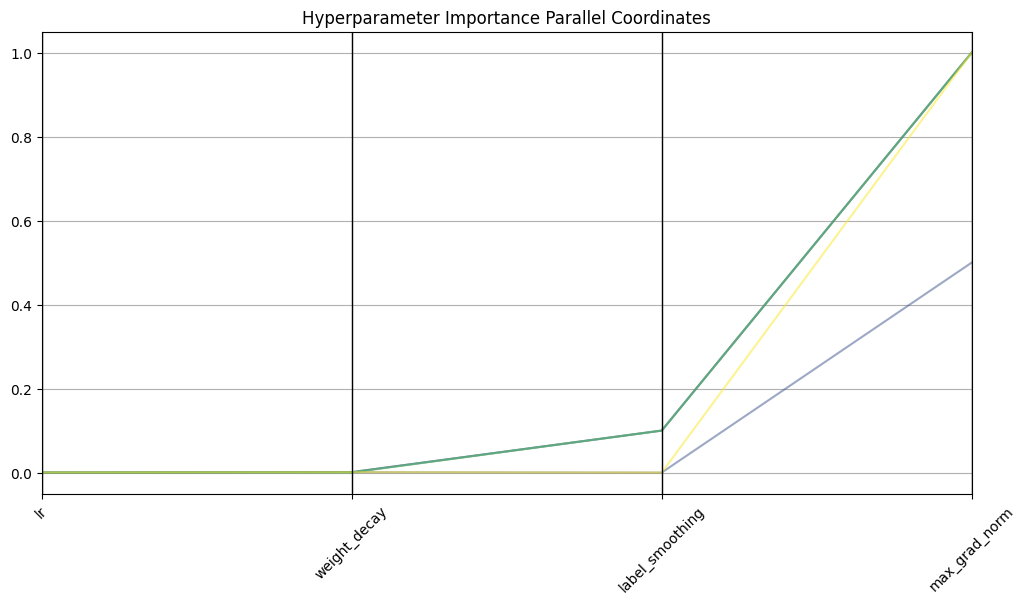

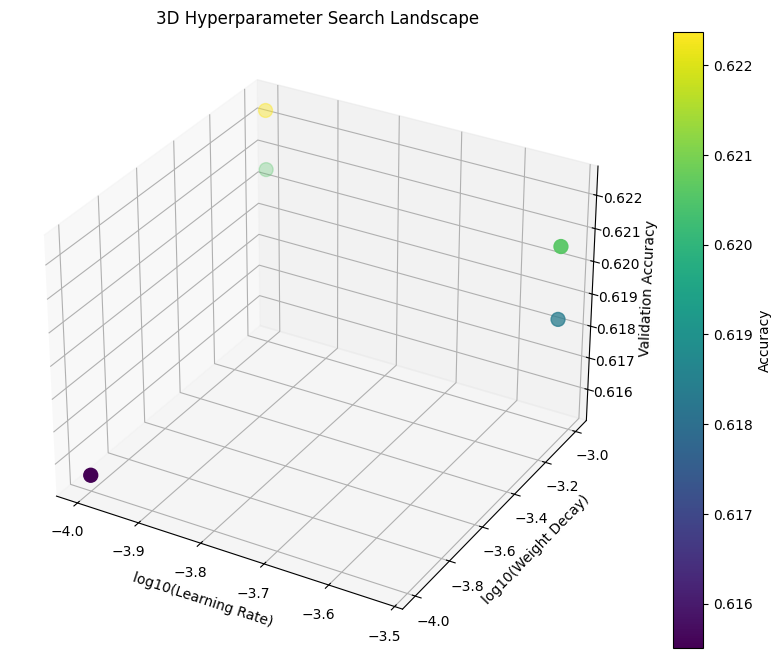

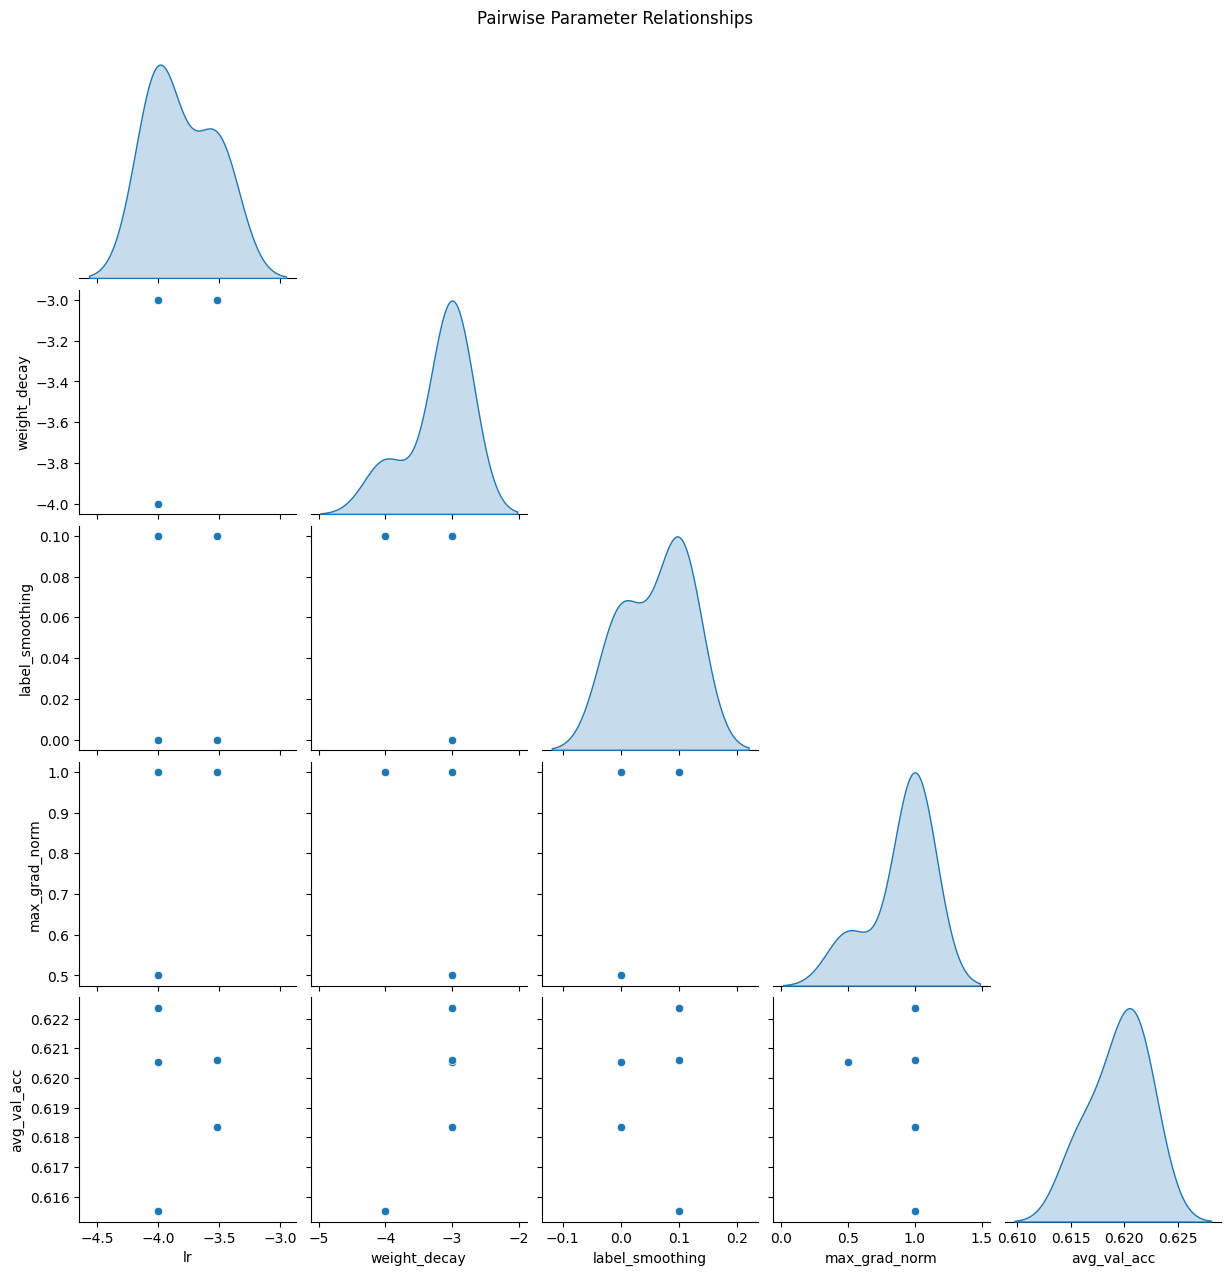

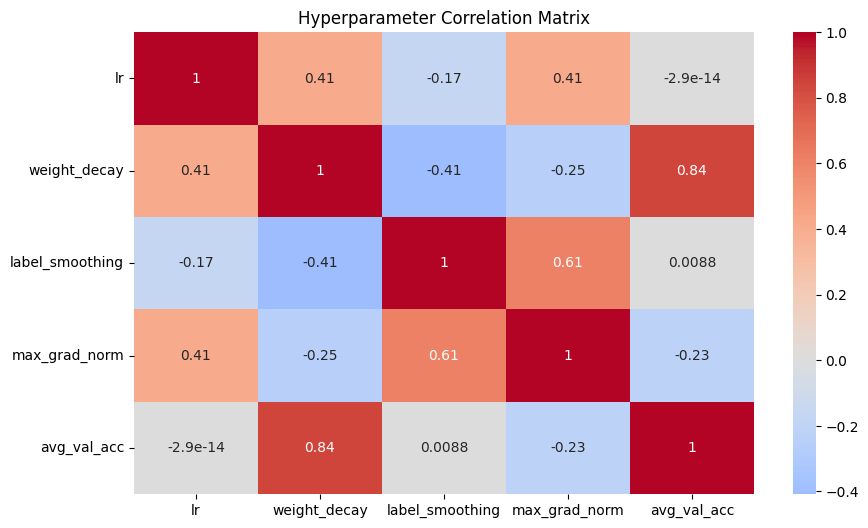

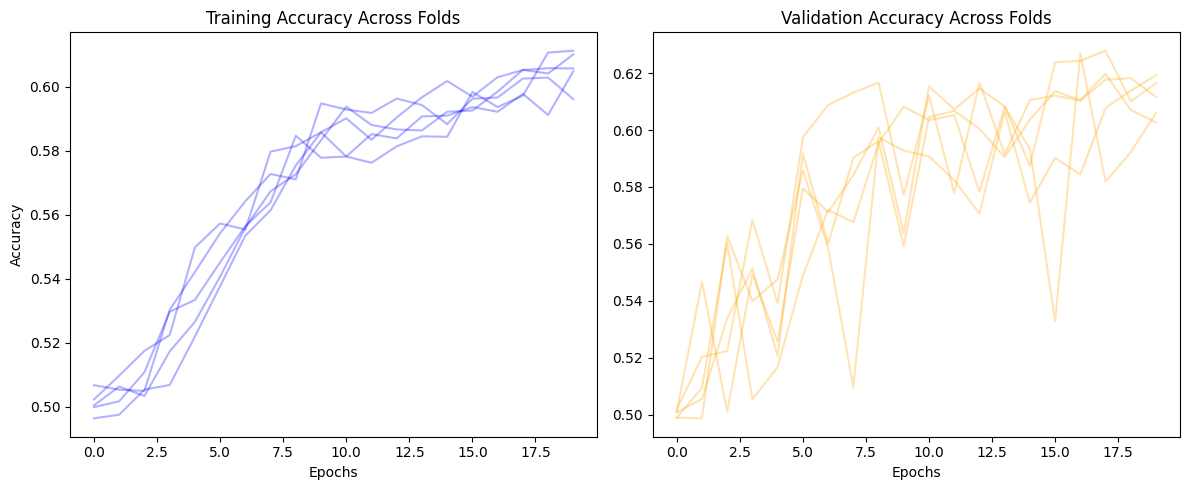

<ipython-input-18-c573e2174c32>:136: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette='viridis')


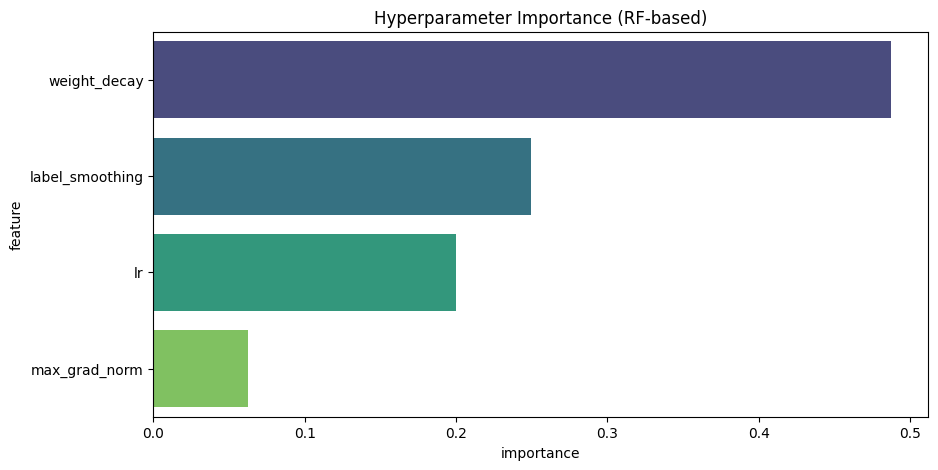

In [ ]:
def plot_hyperparam_importance(results_summary):
    df = pd.DataFrame(results_summary)
    df['normalized_acc'] = (df['avg_val_acc'] - df['avg_val_acc'].min()) / \
                          (df['avg_val_acc'].max() - df['avg_val_acc'].min())

    plt.figure(figsize=(12, 6))
    parallel_coordinates(
        df[['lr', 'weight_decay', 'label_smoothing', 'max_grad_norm', 'normalized_acc']],
        'normalized_acc',
        colormap='viridis',
        alpha=0.5
    )
    plt.title('Hyperparameter Importance Parallel Coordinates')
    plt.gca().legend_.remove()
    plt.xticks(rotation=45)
    plt.show()


def plot_3d_search(results_summary):
    df = pd.DataFrame(results_summary)
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(
        np.log10(df['lr']),
        np.log10(df['weight_decay']),
        df['avg_val_acc'],
        c=df['avg_val_acc'],
        cmap='viridis',
        s=100
    )

    ax.set_xlabel('log10(Learning Rate)')
    ax.set_ylabel('log10(Weight Decay)')
    ax.set_zlabel('Validation Accuracy')
    plt.colorbar(sc, label='Accuracy')
    plt.title('3D Hyperparameter Search Landscape')
    plt.show()


def plot_parameter_correlations(results_summary):
    df = pd.DataFrame(results_summary)
    numeric_cols = ['lr', 'weight_decay', 'label_smoothing', 'max_grad_norm', 'avg_val_acc']

    sns.pairplot(
        df[numeric_cols].apply(lambda x: np.log10(x) if x.name in ['lr', 'weight_decay'] else x),
        diag_kind='kde',
        corner=True
    )
    plt.suptitle('Pairwise Parameter Relationships', y=1.02)
    plt.show()

    plt.figure(figsize=(10, 6))
    corr = df[numeric_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Hyperparameter Correlation Matrix')
    plt.show()


def plot_acc_distribution(results_summary):
    plt.figure(figsize=(10, 6))
    sns.violinplot(
        x='lr',
        y='avg_val_acc',
        data=pd.DataFrame(results_summary),
        inner='quartile',
        palette='Set2'
    )
    plt.xticks(rotation=45)
    plt.title('Validation Accuracy Distribution by Learning Rate')
    plt.show()


def interactive_parallel_plot(results_summary):
    df = pd.DataFrame(results_summary)
    fig = px.parallel_coordinates(
        df,
        color='avg_val_acc',
        dimensions=['lr', 'weight_decay', 'label_smoothing', 'max_grad_norm', 'avg_val_acc'],
        color_continuous_scale=px.colors.sequential.Viridis,
        labels={'lr': 'Learning Rate', 'weight_decay': 'Weight Decay'},
        title='Interactive Hyperparameter Tuning Results'
    )
    fig.show()


def plot_best_config_curves(best_result):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for fold in best_result['fold_train_acc']:
        plt.plot(fold, alpha=0.3, color='blue')
    plt.title('Training Accuracy Across Folds')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    for fold in best_result['fold_val_acc']:
        plt.plot(fold, alpha=0.3, color='orange')
    plt.title('Validation Accuracy Across Folds')
    plt.xlabel('Epochs')
    plt.tight_layout()
    plt.show()


def sensitivity_analysis(results_summary):
    df = pd.DataFrame(results_summary)
    X = df[['lr', 'weight_decay', 'label_smoothing', 'max_grad_norm']].apply(
        lambda x: np.log10(x) if x.name in ['lr', 'weight_decay'] else x
    )
    y = df['avg_val_acc']

    model = RandomForestRegressor()
    model.fit(X, y)

    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 5))
    sns.barplot(x='importance', y='feature', data=importance, palette='viridis')
    plt.title('Hyperparameter Importance (RF-based)')
    plt.show()


plot_hyperparam_importance(summary)
plot_3d_search(summary)
plot_parameter_correlations(summary)
plot_best_config_curves(best_result)
sensitivity_analysis(summary)

In [ ]:
def train_final_model(X_train, y_train, X_test, y_test, best_hparams, epochs=50, batch_size=64):
    lr, wd, smooth, grad_clip = best_hparams

    train_dataset = PhysionetEEGDataset(X_train, y_train, training=True)
    test_dataset = PhysionetEEGDataset(X_test, y_test, training=False)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model = EEGHybrid().to(device)

    y_train_np = y_train.cpu().numpy() if isinstance(y_train, torch.Tensor) else np.array(y_train)

    class_weights = torch.tensor(
        compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np),
        dtype=torch.float32
    ).to(device)


    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=smooth)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=7)

    scaler = GradScaler()
    best_val_loss = float('inf')
    early_stopping = EarlyStopping(patience=10)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(xb)
                loss = criterion(outputs, yb)

            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        scheduler.step(avg_loss)
        print(f"[Epoch {epoch+1}] Training Loss: {avg_loss:.4f}")

        early_stopping(avg_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(yb.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    print(f"\n✅ Final Test Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(all_targets, all_preds, digits=4))

    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Left', 'Right'], yticklabels=['Left', 'Right'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix on Test Set')
    plt.show()

    return model, acc, cm


<ipython-input-18-b60fab73bd9f>:30: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-18-b60fab73bd9f>:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


[Epoch 1] Training Loss: 0.7366
[Epoch 2] Training Loss: 0.7152
[Epoch 3] Training Loss: 0.7026
[Epoch 4] Training Loss: 0.7023
[Epoch 5] Training Loss: 0.6984
[Epoch 6] Training Loss: 0.6957
[Epoch 7] Training Loss: 0.6929
[Epoch 8] Training Loss: 0.6888
[Epoch 9] Training Loss: 0.6893
[Epoch 10] Training Loss: 0.6831
[Epoch 11] Training Loss: 0.6833
[Epoch 12] Training Loss: 0.6856
[Epoch 13] Training Loss: 0.6840
[Epoch 14] Training Loss: 0.6800
[Epoch 15] Training Loss: 0.6781
[Epoch 16] Training Loss: 0.6739
[Epoch 17] Training Loss: 0.6739
[Epoch 18] Training Loss: 0.6725
[Epoch 19] Training Loss: 0.6730
[Epoch 20] Training Loss: 0.6737
[Epoch 21] Training Loss: 0.6686
[Epoch 22] Training Loss: 0.6662
[Epoch 23] Training Loss: 0.6689
[Epoch 24] Training Loss: 0.6678
[Epoch 25] Training Loss: 0.6684
[Epoch 26] Training Loss: 0.6667
[Epoch 27] Training Loss: 0.6651
[Epoch 28] Training Loss: 0.6676
[Epoch 29] Training Loss: 0.6625
[Epoch 30] Training Loss: 0.6603
[Epoch 31] Training

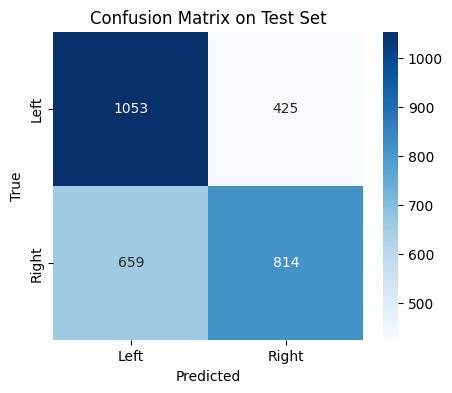

In [ ]:
# Extract best hyperparameter config
# best_hparams = (
#     summary[np.argmax([x['avg_val_acc'] for x in summary])]['lr'],
#     summary[np.argmax([x['avg_val_acc'] for x in summary])]['weight_decay'],
#     summary[np.argmax([x['avg_val_acc'] for x in summary])]['label_smoothing'],
#     summary[np.argmax([x['avg_val_acc'] for x in summary])]['max_grad_norm']
# )

# Best hyperparameters obtained from tuning
best_hparams = (0.0001, 0.001, 0.1, 1.0)

final_model, test_acc, test_cm = train_final_model(
    X_train_tensor, y_train_tensor,
    X_test_tensor, y_test_tensor,
    best_hparams,
    epochs=50
)